# Análisis predictivo del precio de la vivienda

## 1. Fase de Recolección de datos

In [1]:
# Configuramos importación desde Kaggle
from google.colab import files
!pip install -q kaggle

In [2]:
# subimos kaggle.json con el cliente
uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [5]:
!mv kaggle.json /root/.kaggle/kaggle.json

In [6]:
# Descargamos dataset
!kaggle datasets download -d shree1992/housedata

  0% 0.00/432k [00:00<?, ?B/s]
100% 432k/432k [00:00<00:00, 88.4MB/s]


In [7]:
# descomprimimos el dataset porque es un zip
!unzip housedata.zip

Archive:  housedata.zip
  inflating: data.csv                
  inflating: data.dat                
  inflating: output.csv              


## 2. Fase Exploratoria

In [8]:
import pandas as pd  # procesamiento de datos
import numpy as np # algebra lineal

house_data = pd.read_csv("data.csv")

In [9]:
# Un primera visualización de la base para tener una idea de los datos que tenemos.
house_data.head()

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,sqft_above,sqft_basement,yr_built,yr_renovated,street,city,statezip,country
0,2014-05-02 00:00:00,313000.0,3.0,1.50,1340,7912,1.5,0,0,3,1340,0,1955,2005,18810 Densmore Ave N,Shoreline,WA 98133,USA
1,2014-05-02 00:00:00,2384000.0,5.0,2.50,3650,9050,2.0,0,4,5,3370,280,1921,0,709 W Blaine St,Seattle,WA 98119,USA
2,2014-05-02 00:00:00,342000.0,3.0,2.00,1930,11947,1.0,0,0,4,1930,0,1966,0,26206-26214 143rd Ave SE,Kent,WA 98042,USA
3,2014-05-02 00:00:00,420000.0,3.0,2.25,2000,8030,1.0,0,0,4,1000,1000,1963,0,857 170th Pl NE,Bellevue,WA 98008,USA
4,2014-05-02 00:00:00,550000.0,4.0,2.50,1940,10500,1.0,0,0,4,1140,800,1976,1992,9105 170th Ave NE,Redmond,WA 98052,USA


In [10]:
# Nombre de las variables
#    date: fecha en que la casa fue vendida
#    price: precio de la casa
#    bedrooms: número de dormitorios
#    bathrooms: número de baños
#    sqft_living: pies cuadrados de la casa  - la cambiaremos a metros cuadrados - m2_living
#    sqft_lot: pies cuadrados del terreno/lote  - la cambiaremos a metros cuadrados - m2_lot
#    floors: pisos totales (niveles) en la casa
#    waterfront: casa que tiene vista al mar
#    view: vistas de la casa
#    condition: cuan buena es la condición de la casa (general)
#    sqft_above: metros cuadrados de casa aparte del sótano - la cambiaremos a metros cuadrados - m2_above
#    sqft_basement: metros cuadrados del sótano - la cambiaremos a metros cuadrados - m2_basement
#    yr_built: año de construcción
#    yr_renovated: año en que la casa fue renovada
#    street: calle de la casa
#    city:  ciudad
#    statezip: código postal
#    country: país
house_data.columns

Index(['date', 'price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'street', 'city',
       'statezip', 'country'],
      dtype='object')

In [11]:
# número de filas y columnas del dataset
print(f'El dataset house tiene {house_data.shape[0]} filas y {house_data.shape[1]} columnas')

El dataset house tiene 4600 filas y 18 columnas


In [12]:
# Consultamos datos estadísticos generales sobre el dataset
house_data.describe().T

,count,mean,std,min,25%,50%,75%,max
price,4600.0,551962.988473,563834.702547,0.0,322875.00,460943.461539,654962.50,26590000.0
bedrooms,4600.0,3.400870,0.908848,0.0,3.00,3.000000,4.00,9.0
bathrooms,4600.0,2.160815,0.783781,0.0,1.75,2.250000,2.50,8.0
sqft_living,4600.0,2139.346957,963.206916,370.0,1460.00,1980.000000,2620.00,13540.0
sqft_lot,4600.0,14852.516087,35884.436145,638.0,5000.75,7683.000000,11001.25,1074218.0
floors,4600.0,1.512065,0.538288,1.0,1.00,1.500000,2.00,3.5
waterfront,4600.0,0.007174,0.084404,0.0,0.00,0.000000,0.00,1.0
view,4600.0,0.240652,0.778405,0.0,0.00,0.000000,0.00,4.0
condition,4600.0,3.451739,0.677230,1.0,3.00,3.000000,4.00,5.0
sqft_above,4600.0,1827.265435,862.168977,370.0,1190.00,1590.000000,2300.00,9410.0


Pasaremos las variables expresadas en pies cuadrados a metros cuadrados, ya que se entiende mejor en un contexto no anglosajón.

In [13]:
# Pasaremos los datos de pies cuadrados a metros cuadrados (1 sqft = 0.09203 m2)
house_data['m2_living'] = house_data['sqft_living'].apply(lambda x: x*0.09203)
house_data['m2_lot'] = house_data['sqft_lot'].apply(lambda x: x*0.09203)
house_data['m2_above'] = house_data['sqft_above'].apply(lambda x: x*0.09203)
house_data['m2_basement'] = house_data['sqft_basement'].apply(lambda x: x*0.09203)

# eliminamos las columnas expresadas en pies cuadrados
house_data = house_data.drop(['sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement'], axis=1)

In [14]:
print(f'En promedio las casas tienen {round(house_data.m2_living.mean(),1)} metros cuadrados (m2) con un mínimo de {round(house_data.m2_living.min(),1)} m2 y un máximo de {round(house_data.m2_living.max(),1)} m2')
print(f'El precio medio de las casa es {round(house_data.price.mean(),0)} dólares y la mediana del precio es {round(house_data.price.median(),0)} dólares')

En promedio las casas tienen 196.9 metros cuadrados (m2) con un mínimo de 34.1 m2 y un máximo de 1246.1 m2
El precio medio de las casa es 551963.0 dólares y la mediana del precio es 460943.0 dólares


Se observa que el precio promedio de las casa es de USD 551.963 pero con una mediana de USD 460.943. El precio mínimo es USD 0 (se deberá analizar estos casos) y un precio máximo de USD 26.590.000. 
En promedio las casas del dataset tienen 196,9 m<sup>2</sup> con un mínimo de 34,1 m<sup>2</sup> y un máximo de 1246,1 m<sup>2</sup>. Los años de la construcción de las casas van desde 1900 hasta 2014.
Se observa que de las 18 variables 13 son cuantitativas, las restantes no presentadas aquí son cualitativas. Pero podemos confirmar a continuación el tipo de variables.

In [15]:
# consultar el tipo de variables
house_data.dtypes

date             object
price           float64
bedrooms        float64
bathrooms       float64
floors          float64
waterfront        int64
view              int64
condition         int64
yr_built          int64
yr_renovated      int64
street           object
city             object
statezip         object
country          object
m2_living       float64
m2_lot          float64
m2_above        float64
m2_basement     float64
dtype: object

Efectivamente se observa que `date`, `street`, `city`, `statezip` y `country` son variables de tipo object, mientras que las restantes son numéricas, en donde `price`, `beedrooms`, `bathrooms` y `floors` son valores de tipo float (float64) y las restantes son variables enteras (int64)

In [16]:
# Chequeamos si en alguna columna hay valores perdidos
for col in house_data.columns:
  print(f'En la columna {col} hay {house_data[col].isnull().sum()} valores perdidos')

En la columna date hay 0 valores perdidos
En la columna price hay 0 valores perdidos
En la columna bedrooms hay 0 valores perdidos
En la columna bathrooms hay 0 valores perdidos
En la columna floors hay 0 valores perdidos
En la columna waterfront hay 0 valores perdidos
En la columna view hay 0 valores perdidos
En la columna condition hay 0 valores perdidos
En la columna yr_built hay 0 valores perdidos
En la columna yr_renovated hay 0 valores perdidos
En la columna street hay 0 valores perdidos
En la columna city hay 0 valores perdidos
En la columna statezip hay 0 valores perdidos
En la columna country hay 0 valores perdidos
En la columna m2_living hay 0 valores perdidos
En la columna m2_lot hay 0 valores perdidos
En la columna m2_above hay 0 valores perdidos
En la columna m2_basement hay 0 valores perdidos


In [17]:
# Verificamos si hay datos duplicados
house_data[house_data.duplicated()]

,date,price,bedrooms,bathrooms,floors,waterfront,view,condition,yr_built,yr_renovated,street,city,statezip,country,m2_living,m2_lot,m2_above,m2_basement


La base de datos no tiene valores nulos, ni tiene filas duplicadas.

In [18]:
# importamos librerías de visualización
import matplotlib.pyplot as plt
import seaborn as sns

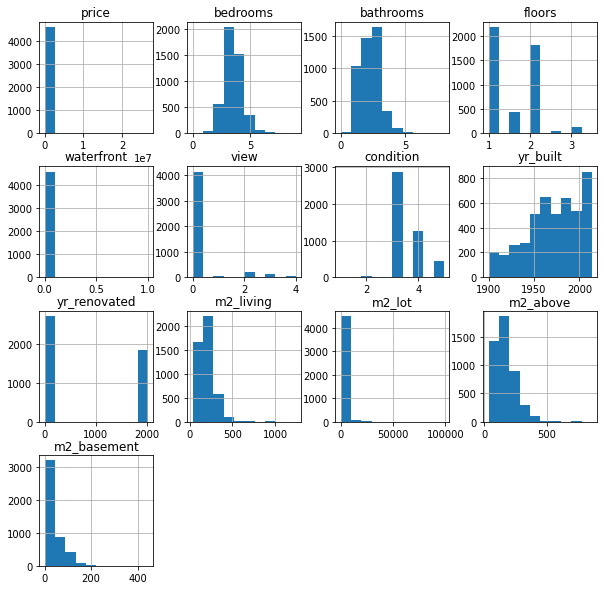

In [19]:
# Visualizamos los histogramas de las variables para tener una idea de la distribución de los datos
house_data.hist(figsize=(10,10))
plt.show()

### Analicemos la variable objetivo `precio`
En el primer gráfico (más arriba) se observa que la variable precio no tiene una distribución clara en el histograma (aparece una barra en valores cercanos a 0) y esto puede ser debido a que existan valores extremos. Anteriormente se había visto que si bien la media era de 552 mil dólares, el valor máximo llegaba a los 26,6 millones de dólares. Por lo que deberemos analizar mejor esta variable.

In [20]:
# Casa con precio 0
print(f'La base de datos muestra un total de {house_data.price.loc[house_data.price==0].count()} casa con precio 0, lo cual llama la atención')

La base de datos muestra un total de 49 casa con precio 0, lo cual llama la atención


Los datos con el precio de las casas igual a 0 deben ser tratados porque afectarían al modelo que intente explicar el precio. Si se consideran como outliers podrían ser eliminados y trabajar con 4551 datos que aun es una muestra grande de precios. Una segunda opción podría ser asignar un precio si se considera que el 0 surgió por un error. Siendo una variable dependiente (el objetivo del modelo) es un poco extraño asignarle un valor con algún método externo al modelo, ya que justamente el modelo intenta explicar a esta variable.
Para no perder estos datos, haré el supuesto de que los precios 0 surgen de un error y la estrategia que aplicaré será trabajar en 2 etapas en el modelo. En la primera etapa usaré la base sin los 49 datos y veré el mejor modelo. Luego en una segunda etapa haré la predicción de los 49 datos con ese modelo y los asignaré en lugar de los precios 0. Finalmente, estimaré nuevamente el modelo considerando todos los datos, con los precios asignados a los 49.
Otro problema que tienen los datos es algunos valores outliers que afectan a los precios como veremos a continuación.

Outliers - Veamos los precios como estan ordenados para ver cuales son los valores extremos

Text(0, 0.5, 'Precio (en millones de USD)')

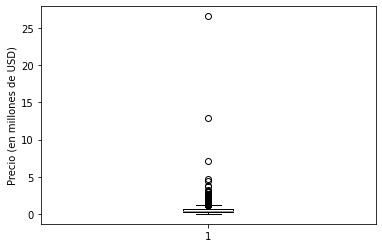

In [21]:
# Mostramos el gráfico de caja para ver la existencia de outliers (círculos por encima de la caja)
plt.boxplot(house_data[house_data.price != 0].price/1000000)
plt.ylabel("Precio (en millones de USD)")

Los círculos por encima de la caja indican la existencia de valores extremos (casi no se puede apreciar la caja). En este caso se aprecia claramente la existencia de muchos y algunos extremadamente grandes que afectarían al modelo. De hecho, en la hipótesis 1 usaremos todo el dataset sin quitar outliers y a partir de la hipótesis 2 usaremos el dataset quitando los outliers.

In [22]:
# precios de las casa en orden ascendente - filtrando los precios 0
house_data[house_data.price!=0].price.sort_values()

4351        7800.0
1219       80000.0
1587       83000.0
4407       83300.0
4415       83300.0
           ...    
2761     4489000.0
2654     4668000.0
2286     7062500.0
4346    12899000.0
4350    26590000.0
Name: price, Length: 4551, dtype: float64

Se aprecia que hay una casa de USD 26.590.000 que es extremo y el siguiente es de USD 12.899.000 a partir de ahí los valores son inferiores a los 7,1 

In [23]:
# Información sobre la casa de valor extremo en la muestra (USD 26,5 millones)
house_data.loc[4350]

date            2014-07-03 00:00:00
price                    26590000.0
bedrooms                        3.0
bathrooms                       2.0
floors                          1.0
waterfront                        0
view                              0
condition                         4
yr_built                       1992
yr_renovated                      0
street            12005 SE 219th Ct
city                           Kent
statezip                   WA 98031
country                         USA
m2_living                  108.5954
m2_lot                    717.18979
m2_above                   108.5954
m2_basement                     0.0
Name: 4350, dtype: object

Como se aprecia la casa de USD 26,6 millones es un claro outlier, no aparece con información que la haga especial por ese precio, tiene 3 dormitorios y 2 baños, es 1 piso de 108 m2, no tiene vistas ni está en frente del mar.

In [24]:
# ANTES DE QUITAR LOS DATOS GUARDAREMOS UNA BASE COMPLETA PARA USARLA EN LA HIPOTESIS 1
house_data_completa = house_data

In [25]:
# Quitamos outliers luego del percentil 90
house_data = house_data[house_data.price<=np.percentile(house_data[house_data.price != 0].price, 90)]

Text(0, 0.5, 'Precio (millones de USD)')

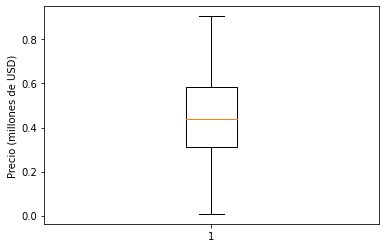

In [26]:
# Gráfica de caja luego de quitar los outliers
plt.boxplot(house_data[(house_data.price != 0)].price/1000000)
plt.ylabel("Precio (millones de USD)")

Ahora la caja se puede apreciar claramente y está centrada, y no aparecen los outliers.

Text(0.5, 1.0, 'Distribución del precio de las casas')

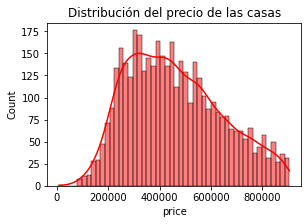

In [27]:
# visualización distribución variable precio luego de quitar los outliers
f=plt.figure(figsize=(10,3))
ax=f.add_subplot(121)
sns.histplot(house_data[house_data.price!=0]['price'], bins=50, kde=True,color='r',ax=ax)
ax.set_title('Distribución del precio de las casas')

Vemos ahora que sin los outliers se aprecia mejor la distribución de los precios.

### Variable metros cuadrados (`m2_living`) de la casa

Text(0.5, 1.0, 'Distribución de los m2 de las casas')

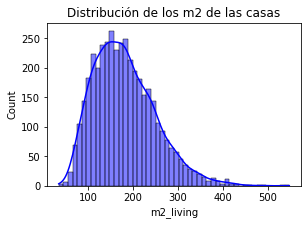

In [28]:
# visualización distribución variable m2_living 
f = plt.figure(figsize=(10,3))
ax = f.add_subplot(121)
sns.histplot(house_data[house_data.price!=0]['m2_living'], bins=50, kde=True,color='b',ax=ax)
ax.set_title('Distribución de los m2 de las casas')


Al igual que en el caso del precio con los m2 de la vivienda se aprecia la distribución

Text(0, 0.5, 'm2_living')

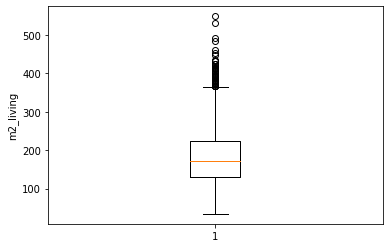

In [29]:
# Gráfica de caja de m2
plt.boxplot(house_data[(house_data.price != 0)].m2_living)
plt.ylabel("m2_living")

se aprecian outliers en el metraje cuadrado de la casa, por lo que habría que quitar algunos para no afectar el modelo

In [30]:
# mts cuadrados de las casa en orden ascendente - filtrando los precios 0
house_data[house_data.price!=0].m2_living.sort_values().tail(10)

3238    431.62070
480     432.54100
1901    434.38160
1360    446.34550
3894    453.70790
4400    461.07030
4091    484.99810
4398    491.44020
634     531.38122
4432    548.49880
Name: m2_living, dtype: float64

In [31]:
# Quitamos outliers luego del percentil 95
house_data = house_data[house_data.m2_living<=np.percentile(house_data[house_data.price != 0].m2_living, 95)]

Text(0, 0.5, 'm2_living')

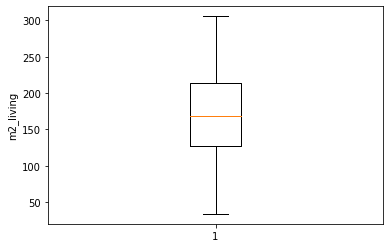

In [32]:
# Gráfica de caja luego de quitar los outliers
plt.boxplot(house_data[(house_data.price != 0)].m2_living)
plt.ylabel("m2_living")

Eliminamos los outliers y la caja aparece centrada

### Variable metros cuadrados del lote o terreno (`m2_lot`)

Text(0.5, 1.0, 'Distribución de los m2 del lote')

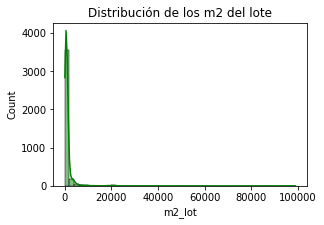

In [33]:
# visualización distribución variable m2_lot
f = plt.figure(figsize = (10,3))
ax = f.add_subplot(121)
sns.histplot(house_data[house_data.price!=0]['m2_lot'], bins=50, kde=True,color='g',ax=ax)
ax.set_title('Distribución de los m2 del lote')

La distribución aparece muy acumulada a la izquiera y el gráfico indica la posibilidad de valores outliers

Text(0, 0.5, 'm2_lot')

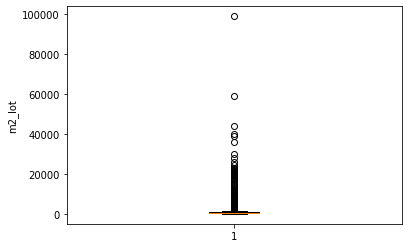

In [34]:
# Gráfica de caja de m2
plt.boxplot(house_data[(house_data.price != 0)].m2_lot)
plt.ylabel("m2_lot")

Se aprecia claramente la presencia de valores outliers en los m2 del lote y la caja no se aprecia.

In [35]:
# mts cuadrados de las casa en orden ascendente - filtrando los precios 0
house_data[house_data.price!=0].m2_lot.sort_values().tail(10)

3448    24453.84348
3122    25856.93286
4353    28239.22144
240     30106.23405
3056    35811.26578
1539    39005.81114
375     40088.26800
3487    44016.84464
2480    59009.91209
1078    98860.28254
Name: m2_lot, dtype: float64

In [36]:
# Quitamos outliers luego del percentil 85%
house_data = house_data[house_data.m2_lot<=np.percentile(house_data[house_data.price != 0].m2_lot, 85)]

Text(0, 0.5, 'm2_lot')

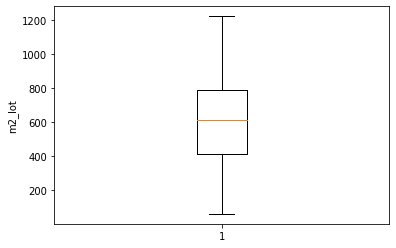

In [37]:
# Gráfica de caja de m2
plt.boxplot(house_data[(house_data.price != 0)].m2_lot)
plt.ylabel("m2_lot")

Ya no aparecen outliers.

### Variables `dormitorios` y `baños`

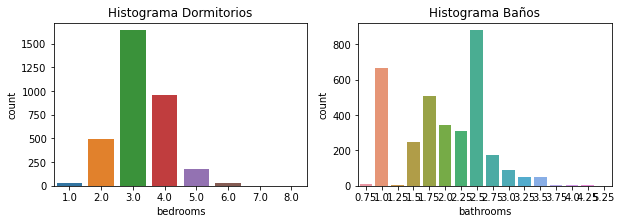

In [38]:
# Vemos la distribución de dormitorios y baños de las casa. 
f = plt.figure(figsize=(10,3))
ax = f.add_subplot(121)
sns.countplot(x='bedrooms', data=house_data)
ax.set_title("Histograma Dormitorios")

ax = f.add_subplot(122)
sns.countplot(x='bathrooms', data=house_data)
ax.set_title("Histograma Baños")
plt.show()

In [39]:
print(f'La moda de dormitorios es {house_data.bedrooms.mode().values[0]} y de baños es {house_data.bathrooms.mode().values[0]}')

La moda de dormitorios es 3.0 y de baños es 2.5


### variables `pisos` y `condición` de la casa

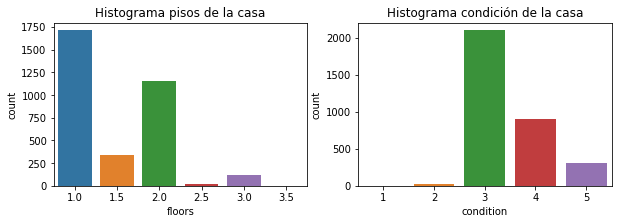

In [40]:
# Vemos la distribución de los pisos y la condición de las casas
f = plt.figure(figsize=(10,3))
ax = f.add_subplot(121)
sns.countplot(x='floors', data=house_data)
ax.set_title("Histograma pisos de la casa")

ax = f.add_subplot(122)
sns.countplot(x='condition', data=house_data)
ax.set_title("Histograma condición de la casa")

plt.show()

In [41]:
print(f'La moda de pisos es {house_data.floors.mode().values[0]} y la moda de condición de las casas es {house_data.condition.mode().values[0]}')

La moda de pisos es 1.0 y la moda de condición de las casas es 3


### Variable vistas de la casa (`view`)

Text(0.5, 1.0, 'Histograma vistas de la casa')

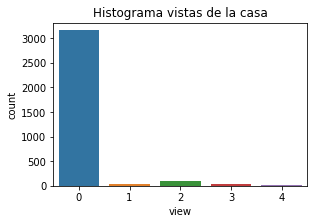

In [42]:
# Vemos la distribución de las vistas de las casas
f = plt.figure(figsize=(10,3))
ax = f.add_subplot(121)
sns.countplot(x='view', data=house_data)
ax.set_title("Histograma vistas de la casa")

In [43]:
sin_vista = (house_data[house_data.view==0].view.count()/house_data.view.count())*100
print(f'El {round(sin_vista,0)}% de las casas de la base de datos no tiene ninguna vista')

El 95.0% de las casas de la base de datos no tiene ninguna vista


### Variable casa frente al mar (`waterfront`)

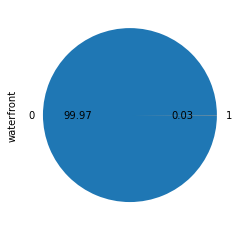

In [44]:
# casa frente al mar
house_data['waterfront'].value_counts().plot(kind='pie', autopct='%.2f')

Menos del 0,1% de las casa se encuentran frente al mar.

### Distribución territorial de las casas

In [45]:
# Todos los datos son de EEUU 
house_data.country.value_counts()

USA    3338
Name: country, dtype: int64

In [46]:
# Los datos son del estado de Washington (WA)
house_data[['state','code']]=house_data.statezip.str.split(" ",expand=True,)
house_data.state.value_counts()


WA    3338
Name: state, dtype: int64

Se observa que todos los datos de la base son de EEUU y especificamente del estado de Washington (WA)

In [47]:
# Al ver las ciudad se observa que pertenecen al Estado de Washington (WA)
# Para ver la ditribución de la variable ciudad podemos primero agrupar los datos por ciudad para luego graficar
ciudad=pd.DataFrame(house_data['city'].value_counts())
ciudad.head()

,city
Seattle,1358
Renton,237
Bellevue,154
Redmond,147
Kent,139


In [48]:
print(f'Se observa que las casa vendidas se distribuyen en {len(ciudad)} ciudades del Estado de Washington (WA) en donde Seattle tiene la mayor cantidad de casas con {round((ciudad.city[0]/ciudad.city.sum()),2)*100}%')

Se observa que las casa vendidas se distribuyen en 42 ciudades del Estado de Washington (WA) en donde Seattle tiene la mayor cantidad de casas con 41.0%


In [49]:
## Creamos una variable binaria en donde Seattle toma el valor 1 y 0 las restantes ciudades
house_data['seattle'] = house_data['city'].apply(lambda x: 1 if x=='Seattle' else 0)
## Creamos una variable binaria para las casas que no tienen vista con valor 1 y 0 cuando tienen vistas
house_data['no_vista'] = house_data['view'].apply(lambda x: 1 if x==0 else 0)

In [50]:
# Aplicamos lo mismo a la base completa para la Hipótesis 1
house_data_completa['seattle'] = house_data_completa['city'].apply(lambda x: 1 if x=='Seattle' else 0)
house_data_completa['no_vista'] = house_data_completa['view'].apply(lambda x: 1 if x==0 else 0)

Text(0.5, 1.0, 'Scatter plot - Precio vs m2 de la casa')

<Figure size 360x360 with 0 Axes>

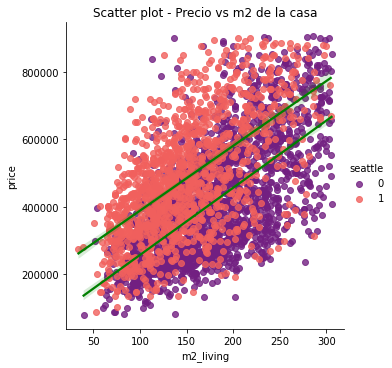

In [51]:
# visualización de la distribución de la variable precio vs m2 cuadrado y Seattle
plt.figure(figsize = (5,5))

sns.lmplot(data=house_data[house_data.price!=0], x = 'm2_living', y = 'price', palette = 'magma', hue = 'seattle',line_kws = {'color': 'g'} )
ax = plt.gca()
ax.set_title("Scatter plot - Precio vs m2 de la casa")


Como se puede apreciar habría una relación positiva entre el precio y los metros cuadrados y cuando se diferencia entre Seattle y las otras ciudades. En el gráfico inferior se observa que la relación positiva y está por encima en el caso de Seattle.

Text(0.5, 1.0, 'Scatter plot - Precio vs m2 de la casa')

<Figure size 720x360 with 0 Axes>

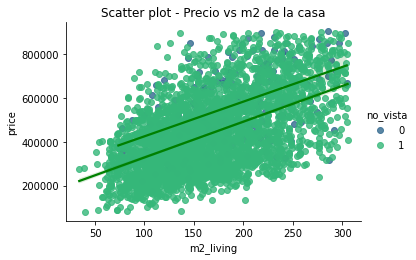

In [52]:
# visualización de la distribución de la variable precio vs m2 de la casa y no_vista
f=plt.figure(figsize=(10,5))
sns.lmplot(data=house_data[house_data.price!=0], x='m2_living', y='price', palette='viridis', hue='no_vista',line_kws={'color': 'g'}, height=3.5, aspect=1.5)
ax = plt.gca()
ax.set_title("Scatter plot - Precio vs m2 de la casa")


En estos gráficos se observa un efecto de nivel dependiendo de que la casa tenga vista o no.

## Incorporar variables como renta familiar, población, viviendas vacías, terremotos, volcanes y tiempo de viaje al trabajo
Antes del análisis de correlaciones quiero incorporar otras variables disponibles en la web, que podrían ser importantes a la hora de explicar el precio de las casas como son la renta media de las familias que viven en la ciudad, la población de las ciudades, el porcentaje de viviendas vacías, el índice de terremotos, el índice de volcanes y el tiempo de viaje al trabajo. Esta información se puede obtener de la página "http://www.usa.com/rank/".

Quiero aclarar que también he probado otras variables, como criminalidad, educación y raza pero aparecen altamente correlacionadas con la variable ingreso por lo cual (por multicolinealidad) las descarto y trabajo solo con ingreso. También probé con el índice de tornados, pero no es significativa y en Washington tiene más importancia el tema de los terremotos y los volcanes que existen.

In [53]:
# Bajamos los datos de ingreso y los ponemos en la base income
income = pd.read_html('http://www.usa.com/rank/washington-state--median-household-income--city-rank.htm', header=0)
income = income[0]

# Bajamos los datos de viviendas vacantes
vacantes = pd.read_html('http://www.usa.com/rank/washington-state--vacant-housing-units-percentage--city-rank.htm?yr=9000&dis=&wist=WA&plow=&phigh=', header=0)
vacantes = vacantes[0]

# Bajamos los datos del índice de terremotos
terremotos = pd.read_html('http://www.usa.com/rank/washington-state--earthquake-index--city-rank.htm?yr=9000&dis=&wist=WA&plow=&phigh=', header=0)
terremotos = terremotos[0]

# Bajamos los datos del índice de volcanes
volcan = pd.read_html('http://www.usa.com/rank/washington-state--volcano-index--city-rank.htm?yr=9000&dis=&wist=WA&plow=&phigh=', header=0)
volcan = volcan[0]

# Bajamos los datos del promedio de tiempo de viaje al trabajo
viaje = pd.read_html('http://www.usa.com/rank/washington-state--mean-travel-time-to-work--city-rank.htm?yr=9000&dis=&wist=WA&plow=&phigh=', header=0)
viaje = viaje[0]


In [54]:
# Observamos la base renta
income.head()

,Rank,Median Household Income ▼,City / Population
0,1.0,"$192,250","Clyde Hill, WA / 3,097"
1,2.0,"$187,500","Yarrow Point, WA / 1,081"
2,3.0,"$182,308","Medina, WA / 3,080"
3,4.0,"$164,375","Beaux Arts Village, WA / 425"
4,5.0,"$161,250","Hunts Point, WA / 487"


In [55]:
# observamos la base de viviendas vacantes
vacantes.head()

,Rank,Vacant Housing Units Percentage ▼,City / Population
0,1.0,100.0%,"Sekiu, WA / 0"
1,2.0,95.4%,"Hat Island, WA / 18"
2,3.0,94.0%,"Glacier, WA / 76"
3,4.0,87.3%,"Oyehut, WA / 13"
4,5.0,87.0%,"Cliffdell, WA / 80"


In [56]:
# observamos la base terremoto
terremotos.head()

,Rank,Earthquake Index ▼,City / Population
0,1.0,37.91,"Ruston, WA / 953"
1,2.0,37.46,"Tacoma, WA / 201,794"
2,3.0,35.38,"Fircrest, WA / 6,592"
3,4.0,34.99,"University Place, WA / 31,670"
4,5.0,26.93,"Wollochet, WA / 6,332"


In [57]:
# observamos la base volcan
volcan.head()

,Rank,Volcano Index ▼,City / Population
0,1.0,0.1152,"Longmire, WA"
1,2.0,0.1105,"Cougar, WA"
2,3.0,0.0968,"Glacier, WA / 76"
3,4.0,0.0877,"Carson, WA / 2,262"
4,5.0,0.0804,"Trout Lake, WA / 464"


In [58]:
# observamos la base tiempo de viaje al trabajo
viaje.head()

,Rank,Mean Travel Time to Work ▼,City / Population
0,1.0,78.3minutes,"Verlot, WA / 93"
1,2.0,69.6minutes,"Ronald, WA / 220"
2,3.0,64.4minutes,"Lake Cavanaugh, WA / 150"
3,4.0,61.8minutes,"Marblemount, WA / 66"
4,5.0,58.0minutes,"Lake Roesiger, WA / 815"


procedemos a limpiar las bases para luego unirlas

In [59]:
# INGRESO Y POBLACIÓN
# El nombre de la columna ingreso tiene un símbolo, lo eliminamos
income.columns = income.columns.str.replace(r'[^a-zA-Z0-9_-]', '', regex=True)
# remplazamos el simbolo $ de la columna de ingreso
income['income']=income['MedianHouseholdIncome'].str.replace(r'[$,]', '', regex=True)
# Separamos la columna (City / Population)
income[['city','population']]=income.CityPopulation.str.split("/",expand=True,)
# Nos quedamos con las columnas city, population e income
incomes=income[['city','population','income']]

In [60]:
# VIVIENDAS VACANTES
# El nombre de la columna viviendas vacantes tiene un símbolo, lo eliminamos
vacantes.columns = vacantes.columns.str.replace(r'[^a-zA-Z0-9_-]', '', regex=True)
# remplazamos el simbolo % de la columna de viviendas vacantes
vacantes['vacantes']=vacantes['VacantHousingUnitsPercentage'].str.replace(r'[%,]', '', regex=True)
# Separamos la columna (City / Population)
vacantes[['city','population']]=vacantes.CityPopulation.str.split("/",expand=True,)
# Nos quedamos con las columnas city y vacantes
vacantes=vacantes[['city','vacantes']]

In [61]:
# TERREMOTOS
# El nombre de la columna terremotos tiene un símbolo, lo eliminamos
terremotos.columns = terremotos.columns.str.replace(r'[^a-zA-Z0-9_-]', '', regex=True)
# creamos la columna terremotos
terremotos['terremotos']=terremotos['EarthquakeIndex']
# Separamos la columna (City / Population)
terremotos[['city','population']]=terremotos.CityPopulation.str.split("/",expand=True,)
# Nos quedamos con las columnas city y terremotos
terremotos=terremotos[['city','terremotos']]

In [62]:
# VOLCANES
# El nombre de la columna volcan tiene un símbolo, lo eliminamos
volcan.columns = volcan.columns.str.replace(r'[^a-zA-Z0-9_-]', '', regex=True)
# creamos la columna viaje
volcan['volcan']=volcan['VolcanoIndex'] #.str.replace(r'[%]', '', regex=True)
# Separamos la columna (City / Population)
volcan[['city','population']]=volcan.CityPopulation.str.split("/",expand=True,)
# Nos quedamos con las columnas city y volcan
volcan=volcan[['city','volcan']]
# Quitamos la coma de los datos de volcan
#volcan=  volcan.assign(volcan=volcan['volcan'].replace(',', '', regex=True))

In [63]:
# TIEMPO DE VIAJE AL TRABAJO
# El nombre de la columna viaje tiene un símbolo, lo eliminamos
viaje.columns = viaje.columns.str.replace(r'[^a-zA-Z0-9_-]', '', regex=True)
# creamos la columna viaje
viaje['viaje']=viaje['MeanTravelTimetoWork'].str.replace(r'[minutes]', '', regex=True)
# Separamos la columna (City / Population)
viaje[['city','population']]=viaje.CityPopulation.str.split("/",expand=True,)
# Nos quedamos con las columnas city y viaje
viaje=viaje[['city','viaje']]

In [64]:
incomes.head()

,city,population,income
0,"Clyde Hill, WA","3,097",192250
1,"Yarrow Point, WA","1,081",187500
2,"Medina, WA","3,080",182308
3,"Beaux Arts Village, WA",425,164375
4,"Hunts Point, WA",487,161250


In [65]:
vacantes.head()

,city,vacantes
0,"Sekiu, WA",100.0
1,"Hat Island, WA",95.4
2,"Glacier, WA",94.0
3,"Oyehut, WA",87.3
4,"Cliffdell, WA",87.0


In [66]:
terremotos.head()

,city,terremotos
0,"Ruston, WA",37.91
1,"Tacoma, WA",37.46
2,"Fircrest, WA",35.38
3,"University Place, WA",34.99
4,"Wollochet, WA",26.93


In [67]:
volcan.head()

,city,volcan
0,"Longmire, WA",0.1152
1,"Cougar, WA",0.1105
2,"Glacier, WA",0.0968
3,"Carson, WA",0.0877
4,"Trout Lake, WA",0.0804


In [68]:
viaje.head()

,city,viaje
0,"Verlot, WA",78.3
1,"Ronald, WA",69.6
2,"Lake Cavanaugh, WA",64.4
3,"Marblemount, WA",61.8
4,"Lake Roesiger, WA",58.0


Ahora podemos unir las bases en una sola que llamaremos `adicional`

In [69]:
# hacemos el merge para incorporar datos de viviendas vacantes a ingresos y población 
adicional=incomes.merge(vacantes, how = 'outer', left_on = 'city', right_on = 'city')

In [70]:
# hacemos el merge para incorporar datos de terremotos
adicional=adicional.merge(terremotos, how = 'outer', left_on = 'city', right_on = 'city')

In [71]:
# hacemos el merge para incorporar datos de volcan
adicional=adicional.merge(volcan, how = 'outer', left_on = 'city', right_on = 'city')

In [72]:
# hacemos el merge para incorporar datos de tiempo de viaje
adicional=adicional.merge(viaje, how = 'outer', left_on = 'city', right_on = 'city')

In [73]:
# vamos la base con los nuevos datos
adicional.head()

,city,population,income,vacantes,terremotos,volcan,viaje
0,"Clyde Hill, WA","3,097",192250,5.6,8.58,0.0075,18.7
1,"Yarrow Point, WA","1,081",187500,7.3,7.51,0.0074,17.3
2,"Medina, WA","3,080",182308,13.2,10.07,0.0074,18.6
3,"Beaux Arts Village, WA",425,164375,3.5,9.31,0.0076,15.5
4,"Hunts Point, WA",487,161250,17.5,7.99,0.0074,16.7


In [74]:
# LIMPIEZA FINAL DE LAS BASES PARA COMPATIBILIZARLAS 
## Quitamos WA del nombre de la ciudad para que luego sea compatible con la columna de la base house_data
adicional= adicional.assign(city=adicional['city'].str.replace( ', WA', ''))
# Quitamos la coma de los datos de poblacion (population)
adicional=  adicional.assign(population=adicional['population'].replace(',', '', regex=True))
# quitamos los espacios en ciudad en la base income y tambien en house_data para compatibilizarlas
adicional= adicional.assign(city=adicional['city'].str.replace( ' ', ''))

house_data= house_data.assign(city=house_data['city'].str.replace( ' ', ''))
# pasamos todo a minuscula
house_data.city = house_data.city.str.lower()
adicional.city = adicional.city.str.lower()

Una vez que tenemos la base `adicional` limpia y que tenemos la columna `city` compatibilizada entre la base `adicional` y la base `house_data`, usamos merge para asignar el ingreso, la pobalcion, las casa vacías, los terremotos, los volcanes y el tiempo de viaje al trabajo a la base `house_data`.

In [75]:
# hacemos el merge para incorporar datos adicionales a la base house_data
house_data=house_data.merge(adicional, how = 'left', left_on = 'city', right_on = 'city')

In [76]:
house_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3338 entries, 0 to 3337
Data columns (total 28 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   date          3338 non-null   object 
 1   price         3338 non-null   float64
 2   bedrooms      3338 non-null   float64
 3   bathrooms     3338 non-null   float64
 4   floors        3338 non-null   float64
 5   waterfront    3338 non-null   int64  
 6   view          3338 non-null   int64  
 7   condition     3338 non-null   int64  
 8   yr_built      3338 non-null   int64  
 9   yr_renovated  3338 non-null   int64  
 10  street        3338 non-null   object 
 11  city          3338 non-null   object 
 12  statezip      3338 non-null   object 
 13  country       3338 non-null   object 
 14  m2_living     3338 non-null   float64
 15  m2_lot        3338 non-null   float64
 16  m2_above      3338 non-null   float64
 17  m2_basement   3338 non-null   float64
 18  state         3338 non-null 

Faltan datos para `population`, `income`, `viaje` y `vacantes` por lo que deberemos hacer asignaciones. Por otro lado, estas variables aparecen como tipo `object` por lo que las cambiaremos a `float64`.

In [77]:
# Llenamos los datos vacíos de viviendas vacantes y viajes con la media
house_data.vacantes = house_data.vacantes.astype('float64')
house_data.vacantes=house_data.vacantes.fillna(house_data.vacantes.mean())
house_data.viaje = house_data.viaje.astype('float64')
house_data.viaje=house_data.viaje.fillna(house_data.viaje.mean())

In [78]:
# vemos que datos faltan
house_data[house_data.isna().any(axis=1)]

,date,price,bedrooms,bathrooms,floors,waterfront,view,condition,yr_built,yr_renovated,...,state,code,seattle,no_vista,population,income,vacantes,terremotos,volcan,viaje
127,2014-05-06 00:00:00,425000.0,4.0,2.0,1.0,0,0,5,1967,0,...,WA,98034,0,1,NaN,NaN,6.201829,6.30,0.0063,27.454586
1233,2014-06-02 00:00:00,439900.0,2.0,2.0,1.5,0,0,5,1909,1988,...,WA,98050,0,1,NaN,NaN,6.201829,6.35,0.0101,27.454586


In [79]:
# Como estaban disponibles en otro sitio, asignamos los datos que faltan de income y population en base a la pagina https://www.point2homes.com/US/Neighborhood/WA
# HAY QUE ESTAR ATENTOS A OBSERVA LOS INDICES DE ARRIBA, DE LAS VARIABLES CON FALTANTES
# inglewoodfinnhill
house_data.at[127, 'income']=139212
house_data.at[127, 'population']=22707
# Preston
house_data.at[1233, 'income']=142316
house_data.at[1233, 'population']=523

In [80]:
# pasamos los valores a tipo float64
house_data.income=house_data.income.astype('float64')
house_data.population=house_data.population.astype('float64')

Text(0.5, 1.0, 'Scatter plot - Precio vs tiempo de viaje al trabajo')

<Figure size 720x360 with 0 Axes>

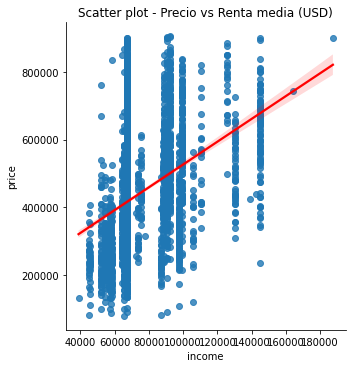

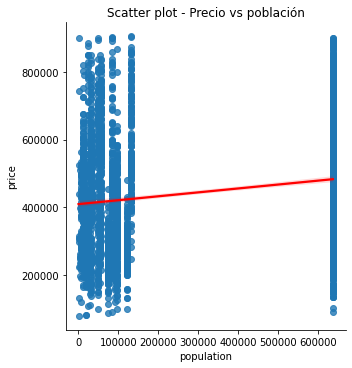

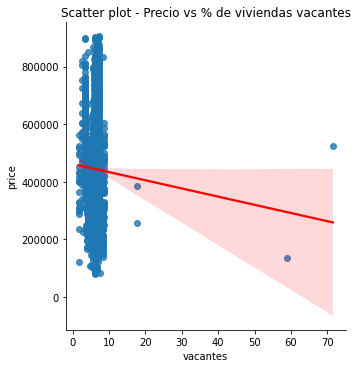

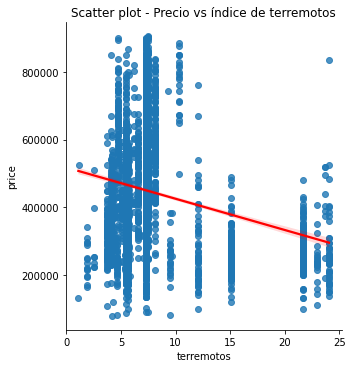

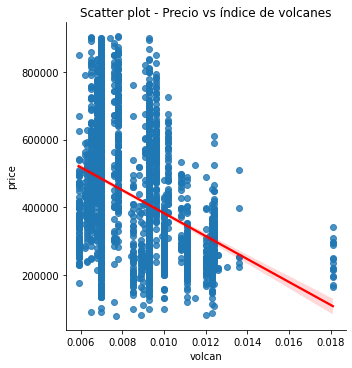

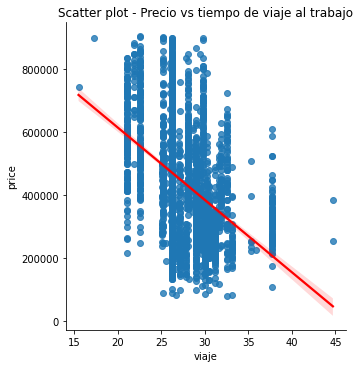

In [81]:
# visualización de la distribución de la variable precio vs las variables adicionales
plt.figure(figsize=(10,5))

sns.lmplot(data=house_data[house_data.price!=0], x = 'income', y = 'price', palette = 'magma', line_kws = {'color': 'r'} )
ax = plt.gca()
ax.set_title("Scatter plot - Precio vs Renta media (USD)")

sns.lmplot(data=house_data[house_data.price!=0], x = 'population', y = 'price', palette = 'magma', line_kws = {'color': 'r'} )
ax = plt.gca()
ax.set_title("Scatter plot - Precio vs población")

sns.lmplot(data=house_data[house_data.price!=0], x = 'vacantes', y = 'price', palette = 'magma', line_kws = {'color': 'r'} )
ax = plt.gca()
ax.set_title("Scatter plot - Precio vs % de viviendas vacantes")

sns.lmplot(data=house_data[house_data.price!=0], x = 'terremotos', y = 'price', palette = 'magma', line_kws = {'color': 'r'} )
ax = plt.gca()
ax.set_title("Scatter plot - Precio vs índice de terremotos")

sns.lmplot(data=house_data[house_data.price!=0], x = 'volcan', y = 'price', palette = 'magma', line_kws = {'color': 'r'} )
ax = plt.gca()
ax.set_title("Scatter plot - Precio vs índice de volcanes")

sns.lmplot(data=house_data[house_data.price!=0], x = 'viaje', y = 'price', palette = 'magma', line_kws = {'color': 'r'} )
ax = plt.gca()
ax.set_title("Scatter plot - Precio vs tiempo de viaje al trabajo")

Se puede observar que la variable renta media (`income`) que incorporamos podría tener un efecto positivo en el precio, al igual que la población (`population`). En cambio, las variables `terremotos`, `volcan` y tiempo de viaje al trabajo (`viaje`) tienen una relación negativa con el precio de la casa. Por otro lado, la variable casas vacías (`vacantes`) no presenta un relación clara, pero lo podremos ver mejor con el análisis de correlaciones.

### Análisis de correlaciones
Analizaremos la correlación entre las variables en la base de datos `house_data` para tener una idea de las variables correlacionadas con la variable objetivo precio y cuales serían variables a incluir en un modelo.

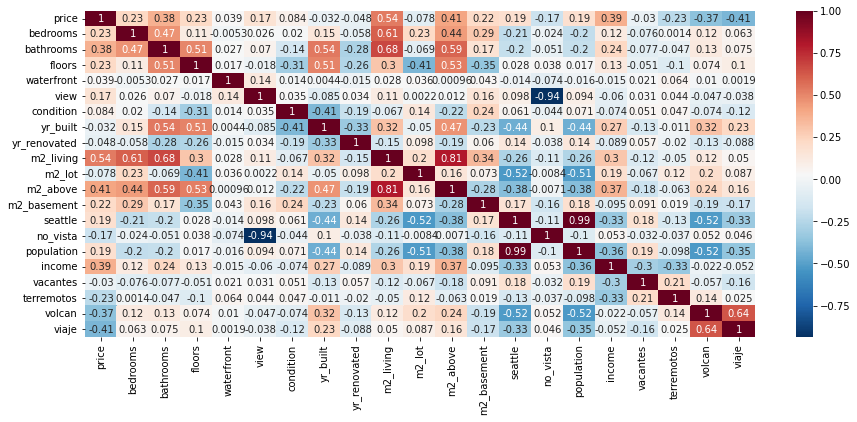

In [82]:
# Análisis de correlación de variables cuantitativas - para toda la base de datos
plt.figure(figsize=(15,6))
corr=house_data[house_data.price != 0].corr()
sns.heatmap(corr, annot=True, cmap="RdBu_r")

Se observa que la variable más correlacionada con el precio son los m2_living (0,54) y luego m2_above (0,41) aunque esta variable está altamente correlaciondas con m2_living (0,81), por lo que no se deberían poner en el modelo juntas. Variables como m2_lot, m2_basement, bathrooms y bedrooms podrían entrar en el modelo junto con m2_living ya que la correlación entre ellas no llega a 0,7, aunque bathrooms y beedrooms tienen correlaciones muy cercanas al 0,7 con m2_living.
Otras variables a incluir y que aparecen correlacionadas con el precio son floors (0,23), waterfront (0,039), condition (0,084), yr_built (-0,032) y yr_renovated (-0,048). La variable view también aparece correlacionada con el precio (0,17) al igual que no_vista (-0,17) que es la variable que creamos, pero entre ellas la correlación es de -0,94 por lo cual habrá que elegir una de las dos.
Seattle tiene una correlación de 0,19 con el precio, pero la variable population que incorporamos tiene una correlación de 0,19 y entre ellas tienen una correlación de 0,99, por lo cual también habrá que elegir una de las dos en el modelo.
Finalmente, las variables que incorporamos, income (0,39), vacantes (-0,03), terremotos (-0,23), volcan (-0,37) y viaje (-0,41) tienen correlación con el precio por lo que sería conveniente incluirlas.

# 3. Fase de entrenamiento y validación 

### HIPÓTESIS 1. Utilizando toda la base sin quitar outliers y con las variables originales de la base que no esten correlacionadas entre sí (ej. m2_living como independiente)

Las variables elegidas se basan en las correlaciones con el precio y a la correlación que existe entre algunas de ellas. 

In [83]:
# Preparamos el dataset de la hipótesis 1
variables_hipot1 = ['price','m2_living', 'bathrooms', 'bedrooms', 'seattle', 'm2_basement', 'condition', 'waterfront', 'm2_lot', 'yr_built', 'floors', 'view','yr_renovated']
# filtramos solo las variables que usaremos en la hipótesis 1
house_data_hipot1=house_data_completa[house_data_completa.price!=0][variables_hipot1]

In [84]:
# creamos variables dummies para las variables categoricas
house_data_hipot1 = pd.get_dummies(data=house_data_hipot1, prefix="floor", prefix_sep="_",
                columns = ['floors'],
                drop_first = True,
                dtype = 'int8')
house_data_hipot1 = pd.get_dummies(data=house_data_hipot1, prefix="view", prefix_sep="_",
                columns = ['view'],
                drop_first = True,
                dtype = 'int8')


In [85]:
## Chequeamos nuestro dataset
house_data_hipot1.head()

,price,m2_living,bathrooms,bedrooms,seattle,m2_basement,condition,waterfront,m2_lot,yr_built,yr_renovated,floor_1.5,floor_2.0,floor_2.5,floor_3.0,floor_3.5,view_1,view_2,view_3,view_4
0,313000.0,123.3202,1.50,3.0,0,0.0000,3,0,728.14136,1955,2005,1,0,0,0,0,0,0,0,0
1,2384000.0,335.9095,2.50,5.0,1,25.7684,5,0,832.87150,1921,0,0,1,0,0,0,0,0,0,1
2,342000.0,177.6179,2.00,3.0,0,0.0000,4,0,1099.48241,1966,0,0,0,0,0,0,0,0,0,0
3,420000.0,184.0600,2.25,3.0,0,92.0300,4,0,739.00090,1963,0,0,0,0,0,0,0,0,0,0
4,550000.0,178.5382,2.50,4.0,0,73.6240,4,0,966.31500,1976,1992,0,0,0,0,0,0,0,0,0


In [86]:
X_hipot1 = house_data_hipot1.drop('price', axis=1)  # variables independientes
y_hipot1 = house_data_hipot1['price'] # variable dependiente

In [87]:
# preparamos el train data y el test data
from sklearn.model_selection import train_test_split
X_hipot1_train, X_hipot1_test, y_hipot1_train, y_hipot1_test = train_test_split(X_hipot1, y_hipot1, test_size=0.2, random_state=43)

In [88]:
# Regresión lineal
from sklearn.linear_model import LinearRegression
regresion_lineal=LinearRegression()
regresion_lineal.fit(X_hipot1_train, y_hipot1_train)

LinearRegression()

#### 3.1 Fase de validación

In [89]:
# importamos el cálculo del Error Cuadrático Medio (ECM)
from sklearn.metrics import mean_squared_error

Utilizaremos la raíz cuadrada del error cuadrático medio (RMSE) por estar expresada en las mismas unidades que la variable objetivo. Adicionalmente usaremos el R<sup>2</sup> para medir el porcentaje de variabilidad explicada por el modelo.

In [90]:
# predecimos los valores y para los datos usados en el entrenamiento
prediccion_entrenamiento1 =  regresion_lineal.predict(X_hipot1_train)

# calculamos la raíz del error cuadrático medio (RMSE = Root Mean Squared Error)
rmse_hipot1_train = np.sqrt(mean_squared_error(y_true = y_hipot1_train, y_pred = prediccion_entrenamiento1))
print('Raíz del Error Cuadrático Medio (RMSE) HIPO1 TRAIN= '+ str(rmse_hipot1_train))

# predecimos los valores y para los datos del test
prediccion_entrenamiento2 =  regresion_lineal.predict(X_hipot1_test)

# calculamos la raíz del error cuadrático medio (RMSE = Root Mean Squared Error)
rmse_hipot1_test = np.sqrt(mean_squared_error(y_true = y_hipot1_test, y_pred = prediccion_entrenamiento2))
print('Raíz del Error Cuadrático Medio (RMSE) HIPO1 TEST= '+ str(rmse_hipot1_test))

# Podemos incorporar el R2 para ver el porcentaje de variación entre la variable predecida y las variables componentes del modelo
r2_hipot1_train = regresion_lineal.score(X_hipot1_train, y_hipot1_train)
print("Coeficiente de determinación HIPO1_TRAIN_R^2:", str(r2_hipot1_train))

# Podemos incorporar el R2 para ver el porcentaje de variación entre la variable predecida y las variables componentes del modelo
r2_hipot1_test = regresion_lineal.score(X_hipot1_test, y_hipot1_test)
print("Coeficiente de determinación HIPO1_TEST_R^2:", str(r2_hipot1_test) )

Raíz del Error Cuadrático Medio (RMSE) HIPO1 TRAIN= 533179.926364378
Raíz del Error Cuadrático Medio (RMSE) HIPO1 TEST= 253021.28343645995
Coeficiente de determinación HIPO1_TRAIN_R^2: 0.20169415579609218
Coeficiente de determinación HIPO1_TEST_R^2: 0.6128108101184323


In [91]:
print(f'la media del precio es {house_data_completa.price.mean()} y la mediana es {house_data_completa.price.median()}')

la media del precio es 551962.9884732141 y la mediana es 460943.46153850004


Cuando usamos la base completa se observa que la media (USD 551.962) difiere de la mediana (USD 460.943) debido a los valores extremos en los precios (outliers). El modelo incluyendo todos los datos tiene un error (RMSE) de USD 533.179 en el train (un valor casi igual a la media) y de USD 253.021 en el test. El R2 es 0,20 en el train y 0,61 en el test.


In [92]:
# Podemos ver como queda el modelo de regresion lineal usando el paquete statsmodels
import statsmodels.api as sm
#
X_hipot11_train = sm.add_constant(X_hipot1_train)  # se agrega una constante al modelo
model = sm.OLS(y_hipot1_train, X_hipot11_train).fit()  # se estima el modelo
#
print(model.summary()) # Se imprime la salida de los coeficientes y los los estadisticos

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.202
Model:                            OLS   Adj. R-squared:                  0.198
Method:                 Least Squares   F-statistic:                     48.14
Date:                Wed, 21 Dec 2022   Prob (F-statistic):          4.44e-161
Time:                        13:14:00   Log-Likelihood:                -53164.
No. Observations:                3640   AIC:                         1.064e+05
Df Residuals:                    3620   BIC:                         1.065e+05
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const         1.675e+06      1e+06      1.673   

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


### HIPÓTESIS 2. Usamos la base quitando los outliers y con el resto de los supuestos de la hipótesis 1

In [93]:
# Preparamos el dataset de la hipótesis 2
variables_hipot2 = ['price','m2_living', 'bathrooms', 'bedrooms', 'seattle', 'm2_basement', 'condition', 'waterfront', 'm2_lot', 'yr_built', 'floors', 'view','yr_renovated']
# filtramos solo las variables que usaremos en la hipótesis 2
house_data_hipot2=house_data[house_data.price!=0][variables_hipot2]

In [94]:
# creamos variables dummies para las variables categoricas
house_data_hipot2 = pd.get_dummies(data=house_data_hipot2, prefix="floor", prefix_sep="_",
                columns = ['floors'],
                drop_first = True,
                dtype = 'int8')
house_data_hipot2 = pd.get_dummies(data=house_data_hipot2, prefix="view", prefix_sep="_",
                columns = ['view'],
                drop_first = True,
                dtype = 'int8')

In [95]:
## Chequeamos nuestro dataset
house_data_hipot2.head()

,price,m2_living,bathrooms,bedrooms,seattle,m2_basement,condition,waterfront,m2_lot,yr_built,yr_renovated,floor_1.5,floor_2.0,floor_2.5,floor_3.0,floor_3.5,view_1,view_2,view_3,view_4
0,313000.0,123.3202,1.50,3.0,0,0.000,3,0,728.14136,1955,2005,1,0,0,0,0,0,0,0,0
1,342000.0,177.6179,2.00,3.0,0,0.000,4,0,1099.48241,1966,0,0,0,0,0,0,0,0,0,0
2,420000.0,184.0600,2.25,3.0,0,92.030,4,0,739.00090,1963,0,0,0,0,0,0,0,0,0,0
3,550000.0,178.5382,2.50,4.0,0,73.624,4,0,966.31500,1976,1992,0,0,0,0,0,0,0,0,0
4,490000.0,80.9864,1.00,2.0,1,0.000,3,0,587.15140,1938,1994,0,0,0,0,0,0,0,0,0


In [96]:
X_hipot2 = house_data_hipot2.drop('price', axis=1)  # variables independientes
y_hipot2 = house_data_hipot2['price'] # variable dependiente

In [97]:
# preparamos el train data y el test data
from sklearn.model_selection import train_test_split
X_hipot2_train, X_hipot2_test, y_hipot2_train, y_hipot2_test = train_test_split(X_hipot2, y_hipot2, test_size=0.2, random_state=43)

In [98]:
# Regresión lineal
from sklearn.linear_model import LinearRegression
regresion_lineal=LinearRegression()
regresion_lineal.fit(X_hipot2_train, y_hipot2_train)

LinearRegression()

#### 3.2 Fase de validación

In [99]:
# predecimos los valores y para los datos usados en el entrenamiento
prediccion_entrenamiento1 = regresion_lineal.predict(X_hipot2_train)


# calculamos la raíz del error cuadrático medio (RMSE = Root Mean Squared Error)
rmse_hipot2_train = np.sqrt(mean_squared_error(y_true = y_hipot2_train, y_pred = prediccion_entrenamiento1))
print('Raíz del Error Cuadrático Medio (MSE) HIPO1 TRAIN= '+ str(rmse_hipot1_train))
print('Raíz del Error Cuadrático Medio (MSE) HIPO2 TRAIN= '+ str(rmse_hipot2_train))

# predecimos los valores y para los datos del test
prediccion_entrenamiento2 =  regresion_lineal.predict(X_hipot2_test)

# calculamos la raíz del error cuadrático medio (RMSE = Root Mean Squared Error)
rmse_hipot2_test = np.sqrt(mean_squared_error(y_true = y_hipot2_test, y_pred = prediccion_entrenamiento2))
print('Raíz del Error Cuadrático Medio (MSE) HIPO1 TEST= '+ str(rmse_hipot1_test))
print('Raíz del Error Cuadratico Medio (MSE) HIPO2 TEST= '+ str(rmse_hipot2_test))

######

# adicionalmente calculamos el R2 para ver el potencial explicativo del modelo
r2_hipot2_train = regresion_lineal.score(X_hipot2_train, y_hipot2_train)
print("Coeficiente de determinación HIPO1_TRAIN_R^2:", str(r2_hipot1_train))
print("Coeficiente de determinación HIPO2_TRAIN_R^2:", str(r2_hipot2_train))

# calculamos el R2 para ver el potencial explicativo del modelo
r2_hipot2_test = regresion_lineal.score(X_hipot2_test, y_hipot2_test)
print("Coeficiente de determinación HIPO1_TEST_R^2:", str(r2_hipot1_test))
print("Coeficiente de determinación HIPO2_TEST_R^2:", str(r2_hipot2_test))

Raíz del Error Cuadrático Medio (MSE) HIPO1 TRAIN= 533179.926364378
Raíz del Error Cuadrático Medio (MSE) HIPO2 TRAIN= 126689.12491191045
Raíz del Error Cuadrático Medio (MSE) HIPO1 TEST= 253021.28343645995
Raíz del Error Cuadratico Medio (MSE) HIPO2 TEST= 137731.33800628598
Coeficiente de determinación HIPO1_TRAIN_R^2: 0.20169415579609218
Coeficiente de determinación HIPO2_TRAIN_R^2: 0.47303672220803616
Coeficiente de determinación HIPO1_TEST_R^2: 0.6128108101184323
Coeficiente de determinación HIPO2_TEST_R^2: 0.4042043112324465


In [100]:
print(f'la media del precio es {house_data.price.mean()} y la mediana es {house_data.price.median()}')

la media del precio es 440559.87774070073 y la mediana es 417911.857143


Quitando los outliers ahora la media (USD 440.559) se acerca a la mediana (USD 417.911). Notese también que el error bajo sensiblemente a USD 126.689 en el train y USD 137.731 en el test, valores inferiores al valor medio y mediana.

In [101]:
# Podemos ver como queda el modelo de regresion lineal usando el paquete statsmodels
import statsmodels.api as sm
#
X_hipot21_train = sm.add_constant(X_hipot2_train)  # se agrega una constante al modelo
model = sm.OLS(y_hipot2_train, X_hipot21_train).fit()  # se estima el modelo
#
print(model.summary()) # Se imprime la salida de los coeficientes y los los estadisticos

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.473
Model:                            OLS   Adj. R-squared:                  0.469
Method:                 Least Squares   F-statistic:                     131.1
Date:                Wed, 21 Dec 2022   Prob (F-statistic):               0.00
Time:                        13:14:22   Log-Likelihood:                -34870.
No. Observations:                2648   AIC:                         6.978e+04
Df Residuals:                    2629   BIC:                         6.989e+04
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const         1.766e+06   2.86e+05      6.174   

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


### HIPÓTESIS 3. Seguimos con los supuestos de la hipótesis 2 (quitando los outliers) y aplicando StandardScaler

Probaremos la normalización de la variable objetivo, pero en este caso al ser un modelo de regresión lineal no se piensa que pueda haber un efecto importante, más bien el efecto será de reescalado. Para ver esto, luego de hacer la predicción con el modelo normalizado, transformaré las variables a la escala original en dolares y comprobaré los indicadores RMSE y R<sup>2</sup> para ver si hay cambios.

In [102]:
# Preparamos el dataset de la hipótesis 3
variables_hipot3 = ['price','m2_living', 'bathrooms', 'bedrooms', 'seattle', 'm2_basement', 'condition', 'waterfront', 'm2_lot', 'yr_built', 'floors', 'view','yr_renovated']
# filtramos solo las variables que usaremos en la hipótesis 3
house_data_hipot3=house_data[house_data.price!=0][variables_hipot3]

In [103]:
# creamos variables dummies para las variables categoricas
house_data_hipot3 = pd.get_dummies(data=house_data_hipot3, prefix="floor", prefix_sep="_",
                columns = ['floors'],
                drop_first = True,
                dtype = 'int8')
house_data_hipot3 = pd.get_dummies(data=house_data_hipot3, prefix="view", prefix_sep="_",
                columns = ['view'],
                drop_first = True,
                dtype = 'int8')

In [104]:
## Chequeamos nuestro dataset
house_data_hipot3.head()

,price,m2_living,bathrooms,bedrooms,seattle,m2_basement,condition,waterfront,m2_lot,yr_built,yr_renovated,floor_1.5,floor_2.0,floor_2.5,floor_3.0,floor_3.5,view_1,view_2,view_3,view_4
0,313000.0,123.3202,1.50,3.0,0,0.000,3,0,728.14136,1955,2005,1,0,0,0,0,0,0,0,0
1,342000.0,177.6179,2.00,3.0,0,0.000,4,0,1099.48241,1966,0,0,0,0,0,0,0,0,0,0
2,420000.0,184.0600,2.25,3.0,0,92.030,4,0,739.00090,1963,0,0,0,0,0,0,0,0,0,0
3,550000.0,178.5382,2.50,4.0,0,73.624,4,0,966.31500,1976,1992,0,0,0,0,0,0,0,0,0
4,490000.0,80.9864,1.00,2.0,1,0.000,3,0,587.15140,1938,1994,0,0,0,0,0,0,0,0,0


In [105]:
X_hipot3 = house_data_hipot3.drop('price', axis=1)  # variables independientes
y_hipot3 = house_data_hipot3['price'] # variable dependiente

In [106]:
# Escalamos la variable charges para hacerla más estandar
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

# Los algoritmos de preprocessing de sklearn están preparados para convertir matrices por lo que tenemos que hacer una transformación de nuestra variable y
# ya que es una variable de tipo Series
# para ello hacemos un .to_numpy() que nos convierte la serie en un array y luego hacemos reshape (-1, 1) que transforma un array de 1xn en una matriz de nx1
y_hipot3 = scaler.fit_transform(y_hipot3.to_numpy().reshape(-1,1))
# volvemos a transformar nuestra variable en un array de 1xn
y_hipot3 = y_hipot3.reshape(1, -1)[0]

In [107]:
# preparamos el train data y el test data
from sklearn.model_selection import train_test_split
X_hipot3_train, X_hipot3_test, y_hipot3_train, y_hipot3_test = train_test_split(X_hipot3, y_hipot3, test_size=0.2, random_state=43)

In [108]:
# Regresión lineal
from sklearn.linear_model import LinearRegression
regresion_lineal=LinearRegression()
regresion_lineal.fit(X_hipot3_train, y_hipot3_train)

LinearRegression()

#### 3.3 Fase de validación

In [109]:
print(f'Hay que observar que por la normalización la variable objetivo ahora alcanza un valor mínimo en {y_hipot3.min()} y_un valor máximo de {y_hipot3.max()}')

Hay que observar que por la normalización la variable objetivo ahora alcanza un valor mínimo en -2.07698388708367 y_un valor máximo de 2.6284946853908093


In [110]:
# predecimos los valores y para los datos usados en el entrenamiento
prediccion_entrenamiento1 =  regresion_lineal.predict(X_hipot3_train)
# luego de realizada la predicción volvemos a transformar los valores la escala original para comparar con el modelo anterior
inverse_pred1 = scaler.inverse_transform(prediccion_entrenamiento1.reshape(-1,1))
inverse_y_hipot3_train = scaler.inverse_transform(y_hipot3_train.reshape(-1,1))

# calculamos la raíz del error cuadrático medio (RMSE = Root Mean Squared Error)
rmse_hipot3_train = np.sqrt(mean_squared_error(y_true = inverse_y_hipot3_train, y_pred = inverse_pred1))
print('Raíz del Error Cuadrático Medio (RMSE) HIPO1 TRAIN= '+ str(rmse_hipot1_train))
print('Raíz del Error Cuadrático Medio (RMSE) HIPO2 TRAIN= '+ str(rmse_hipot2_train))
print('Raíz del Error Cuadrático Medio (RMSE) HIPO3 TRAIN= '+ str(rmse_hipot3_train))

# predecimos los valores y para los datos del test
prediccion_entrenamiento2 =  regresion_lineal.predict(X_hipot3_test)
# luego de realizada la predicción volvemos a transformar los valores la escala original para comparar con el modelo anterior
inverse_pred2= scaler.inverse_transform(prediccion_entrenamiento2.reshape(-1,1))
inverse_y_hipot3_test=scaler.inverse_transform(y_hipot3_test.reshape(-1,1))

# calculamos la raíz del error cuadrático medio (RMSE = Root Mean Squared Error)
rmse_hipot3_test = np.sqrt(mean_squared_error(y_true = inverse_y_hipot3_test, y_pred = inverse_pred2))
print('Raíz del Error Cuadrático Medio (RMSE) HIPO1 TEST= '+ str(rmse_hipot1_test))
print('Raíz del Error Cuadratico Medio (RMSE) HIPO2 TEST= '+ str(rmse_hipot2_test))
print('Raíz del Error Cuadratico Medio (RMSE) HIPO3 TEST= '+ str(rmse_hipot3_test))

######

# adicionalmente calculamos el R2 para ver el potencial explicativo del modelo
r2_hipot3_train = regresion_lineal.score(X_hipot3_train, y_hipot3_train)
print("Coeficiente de determinación HIPO1_TRAIN_R^2:", str(r2_hipot1_train))
print("Coeficiente de determinación HIPO2_TRAIN_R^2:", str(r2_hipot2_train))
print("Coeficiente de determinación HIPO3_TRAIN_R^2:", str(r2_hipot3_train))

# calculamos el R2 para ver el potencial explicativo del modelo
r2_hipot3_test = regresion_lineal.score(X_hipot3_test, y_hipot3_test)
print("Coeficiente de determinación HIPO1_TEST_R^2:", str(r2_hipot1_test))
print("Coeficiente de determinación HIPO2_TEST_R^2:", str(r2_hipot2_test))
print("Coeficiente de determinación HIPO3_TEST_R^2:", str(r2_hipot3_test))

Raíz del Error Cuadrático Medio (RMSE) HIPO1 TRAIN= 533179.926364378
Raíz del Error Cuadrático Medio (RMSE) HIPO2 TRAIN= 126689.12491191045
Raíz del Error Cuadrático Medio (RMSE) HIPO3 TRAIN= 126689.12491191045
Raíz del Error Cuadrático Medio (RMSE) HIPO1 TEST= 253021.28343645995
Raíz del Error Cuadratico Medio (RMSE) HIPO2 TEST= 137731.33800628598
Raíz del Error Cuadratico Medio (RMSE) HIPO3 TEST= 137731.33800628566
Coeficiente de determinación HIPO1_TRAIN_R^2: 0.20169415579609218
Coeficiente de determinación HIPO2_TRAIN_R^2: 0.47303672220803616
Coeficiente de determinación HIPO3_TRAIN_R^2: 0.4730367222080363
Coeficiente de determinación HIPO1_TEST_R^2: 0.6128108101184323
Coeficiente de determinación HIPO2_TEST_R^2: 0.4042043112324465
Coeficiente de determinación HIPO3_TEST_R^2: 0.4042043112324496


Vemos que la transformación standard en la regresión lineal no afecta al resultado una vez que las variables se vuelven a medir en la unidad original (uso de inverse_transform())

In [111]:
# Podemos ver como queda el modelo de regresion lineal usando el paquete statsmodels
import statsmodels.api as sm
#
X_hipot31_train = sm.add_constant(X_hipot3_train)  # se agrega una constante al modelo
model = sm.OLS(y_hipot3_train, X_hipot31_train).fit()  # se estima el modelo
#
print(model.summary()) # Se imprime la salida de los coeficientes y los los estadisticos

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.473
Model:                            OLS   Adj. R-squared:                  0.469
Method:                 Least Squares   F-statistic:                     131.1
Date:                Wed, 21 Dec 2022   Prob (F-statistic):               0.00
Time:                        13:14:48   Log-Likelihood:                -2897.0
No. Observations:                2648   AIC:                             5832.
Df Residuals:                    2629   BIC:                             5944.
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            7.5372      1.631      4.621   

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


Se puede ver también aquí que los errores estandar son iguales a los de la hipótesis anterior y lo que cambian son los coeficientes (porque la variable está normalizada)

### HIPÓTESIS 4. Consideramos el logaritmo del precio

En economía se suele usar mucho la transformación logarítmica para reducir la variabilidad, veremos que efecto tiene aquí.

In [112]:
# Calculamos el logaritmo de los precios
house_data['lprice']=house_data.price.apply(lambda x: np.log(x))

In [113]:
# Preparamos el dataset de la hipótesis 4
variables_hipot4 = ['lprice','m2_living', 'bathrooms', 'bedrooms', 'seattle', 'm2_basement', 'condition', 'waterfront', 'm2_lot', 'yr_built', 'floors', 'view','yr_renovated']
# filtramos solo las variables que usaremos en la hipotesis 4
house_data_hipot4=house_data[house_data.price!=0][variables_hipot4]

In [114]:
# creamos variables dummies para las variables categoricas
house_data_hipot4 = pd.get_dummies(data=house_data_hipot4, prefix="floor", prefix_sep="_",
                columns = ['floors'],
                drop_first = True,
                dtype = 'int8')
house_data_hipot4 = pd.get_dummies(data=house_data_hipot4, prefix="view", prefix_sep="_",
                columns = ['view'],
                drop_first = True,
                dtype = 'int8')

In [115]:
# chequeamos nuestro dataset
house_data_hipot4.head()

,lprice,m2_living,bathrooms,bedrooms,seattle,m2_basement,condition,waterfront,m2_lot,yr_built,yr_renovated,floor_1.5,floor_2.0,floor_2.5,floor_3.0,floor_3.5,view_1,view_2,view_3,view_4
0,12.653958,123.3202,1.50,3.0,0,0.000,3,0,728.14136,1955,2005,1,0,0,0,0,0,0,0,0
1,12.742566,177.6179,2.00,3.0,0,0.000,4,0,1099.48241,1966,0,0,0,0,0,0,0,0,0,0
2,12.948010,184.0600,2.25,3.0,0,92.030,4,0,739.00090,1963,0,0,0,0,0,0,0,0,0,0
3,13.217674,178.5382,2.50,4.0,0,73.624,4,0,966.31500,1976,1992,0,0,0,0,0,0,0,0,0
4,13.102161,80.9864,1.00,2.0,1,0.000,3,0,587.15140,1938,1994,0,0,0,0,0,0,0,0,0


In [116]:
X_hipot4 = house_data_hipot4.drop('lprice', axis=1)  # variables independientes
y_hipot4 = house_data_hipot4['lprice'] # variable dependiente

In [117]:
# preparamos el train data y el test data
X_hipot4_train, X_hipot4_test, y_hipot4_train, y_hipot4_test = train_test_split(X_hipot4, y_hipot4, test_size=0.2, random_state=43)

In [118]:
# Regresión lineal
from sklearn.linear_model import LinearRegression
regresion_lineal=LinearRegression()
regresion_lineal.fit(X_hipot4_train, y_hipot4_train)

LinearRegression()

#### 3.4 Fase de validación

Al igual que en la estandarización, aquí debemos invertir el proceso del logarítmos (exponenciación) luego de predecir con el modelo. De esta forma, podremos calcular el RMSE y que sea comparable con los modelos anteriores en que la variable `price` se usa en diferentes escalas.

In [119]:
# predecimos los valores y para los datos usados en el entrenamiento
prediccion_entrenamiento1 =  regresion_lineal.predict(X_hipot4_train)
# luego de realizada la predicción volvemos a transformar los valores la escala original para comparar con el modelo anterior
inverse_pred1 = np.exp(prediccion_entrenamiento1)
inverse_y_hipot4_train = np.exp(y_hipot4_train)

# calculamos la raíz del error cuadrático medio (RMSE = Root Mean Squared Error)
rmse_hipot4_train = np.sqrt(mean_squared_error(y_true = inverse_y_hipot4_train, y_pred = inverse_pred1))
print('Raíz del Error Cuadrático Medio (RMSE) HIPO1 TRAIN= '+ str(rmse_hipot1_train))
print('Raíz del Error Cuadrático Medio (RMSE) HIPO2 TRAIN= '+ str(rmse_hipot2_train))
print('Raíz del Error Cuadrático Medio (RMSE) HIPO3 TRAIN= '+ str(rmse_hipot3_train))
print('Raíz del Error Cuadrático Medio (RMSE) HIPO4 TRAIN= '+ str(rmse_hipot4_train))

# predecimos los valores y para los datos del test
prediccion_entrenamiento2 =  regresion_lineal.predict(X_hipot4_test)
# luego de realizada la predicción volvemos a transformar los valores la escala original para comparar con el modelo anterior
inverse_pred2 = np.exp(prediccion_entrenamiento2)
inverse_y_hipot4_test = np.exp(y_hipot4_test)

# calculamos la raíz del error cuadrático medio (RMSE = Root Mean Squared Error)
rmse_hipot4_test = np.sqrt(mean_squared_error(y_true = inverse_y_hipot4_test, y_pred = inverse_pred2))
print('Raíz del Error Cuadrático Medio (RMSE) HIPO1 TEST= '+ str(rmse_hipot1_test))
print('Raíz del Error Cuadratico Medio (RMSE) HIPO2 TEST= '+ str(rmse_hipot2_test))
print('Raíz del Error Cuadratico Medio (RMSE) HIPO3 TEST= '+ str(rmse_hipot3_test))
print('Raíz del Error Cuadratico Medio (RMSE) HIPO4 TEST= '+ str(rmse_hipot4_test))

######

# adicionalmente calculamos el R2 para ver el potencial explicativo del modelo
r2_hipot4_train = regresion_lineal.score(X_hipot4_train, y_hipot4_train)
print("Coeficiente de determinación HIPO1_TRAIN_R^2:", str(r2_hipot1_train))
print("Coeficiente de determinación HIPO2_TRAIN_R^2:", str(r2_hipot2_train))
print("Coeficiente de determinación HIPO3_TRAIN_R^2:", str(r2_hipot3_train))
print("Coeficiente de determinación HIPO4_TRAIN_R^2:", str(r2_hipot4_train))

# calculamos el R2 para ver el potencial explicativo del modelo
r2_hipot4_test = regresion_lineal.score(X_hipot4_test, y_hipot4_test)
print("Coeficiente de determinación HIPO1_TEST_R^2:", str(r2_hipot1_test))
print("Coeficiente de determinación HIPO2_TEST_R^2:", str(r2_hipot2_test))
print("Coeficiente de determinación HIPO3_TEST_R^2:", str(r2_hipot3_test))
print("Coeficiente de determinación HIPO4_TEST_R^2:", str(r2_hipot4_test))

Raíz del Error Cuadrático Medio (RMSE) HIPO1 TRAIN= 533179.926364378
Raíz del Error Cuadrático Medio (RMSE) HIPO2 TRAIN= 126689.12491191045
Raíz del Error Cuadrático Medio (RMSE) HIPO3 TRAIN= 126689.12491191045
Raíz del Error Cuadrático Medio (RMSE) HIPO4 TRAIN= 130142.62837944155
Raíz del Error Cuadrático Medio (RMSE) HIPO1 TEST= 253021.28343645995
Raíz del Error Cuadratico Medio (RMSE) HIPO2 TEST= 137731.33800628598
Raíz del Error Cuadratico Medio (RMSE) HIPO3 TEST= 137731.33800628566
Raíz del Error Cuadratico Medio (RMSE) HIPO4 TEST= 145250.2033567137
Coeficiente de determinación HIPO1_TRAIN_R^2: 0.20169415579609218
Coeficiente de determinación HIPO2_TRAIN_R^2: 0.47303672220803616
Coeficiente de determinación HIPO3_TRAIN_R^2: 0.4730367222080363
Coeficiente de determinación HIPO4_TRAIN_R^2: 0.46036513038959403
Coeficiente de determinación HIPO1_TEST_R^2: 0.6128108101184323
Coeficiente de determinación HIPO2_TEST_R^2: 0.4042043112324465
Coeficiente de determinación HIPO3_TEST_R^2: 0.4

Aplicando el logaritmo no se obtiene un mejor resultado que con los dos modelos previos, por lo que descartamos el modelo con la variable objetivo expresada en logarítmos.

In [120]:
# Podemos ver como queda el modelo de regresión lineal usando el paquete statsmodels
import statsmodels.api as sm
#
X_hipot41_train = sm.add_constant(X_hipot4_train)  # se agrega una constante al modelo
model = sm.OLS(y_hipot4_train, X_hipot41_train).fit()  # se estima el modelo
#
print(model.summary())  # Se imprime la salida de los coeficientes y los los estadísticos

                            OLS Regression Results                            
Dep. Variable:                 lprice   R-squared:                       0.460
Model:                            OLS   Adj. R-squared:                  0.457
Method:                 Least Squares   F-statistic:                     124.6
Date:                Wed, 21 Dec 2022   Prob (F-statistic):               0.00
Time:                        13:15:15   Log-Likelihood:                -614.06
No. Observations:                2648   AIC:                             1266.
Df Residuals:                    2629   BIC:                             1378.
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           14.8322      0.689     21.535   

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


### HIPÓTESIS 5. Consideramos las variables que agregamos (ingreso, población, casas vacías, terremotos, volcanes y tiempo de viaje al trabajo) en el dataset sin los outliers

In [121]:
# Preparamos el dataset de la hipótesis 5
variables_hipot5 = ['price','m2_living', 'income','population', 'vacantes',  'terremotos', 'viaje', 'volcan',  'm2_basement', 'condition',  'waterfront', 'm2_lot', 'yr_built', 'floors', 'view','yr_renovated']
# filtramos solo las variables que usaremos en la hipótesis 5

house_data_hipot5 = house_data[variables_hipot5]

In [122]:
# creamos variables dummies para las variables categóricas
house_data_hipot5 = pd.get_dummies(data=house_data_hipot5, prefix="floor", prefix_sep="_",
                columns = ['floors'],
                drop_first = True,
                dtype = 'int8')
house_data_hipot5 = pd.get_dummies(data=house_data_hipot5, prefix="view", prefix_sep="_",
                 columns = ['view'],
                 drop_first = True,
                 dtype = 'int8')

In [123]:
# chequeamos nuestro dataset
house_data_hipot5.head()

,price,m2_living,income,population,vacantes,terremotos,viaje,volcan,m2_basement,condition,...,yr_renovated,floor_1.5,floor_2.0,floor_2.5,floor_3.0,floor_3.5,view_1,view_2,view_3,view_4
0,313000.0,123.3202,64096.0,54254.0,4.1,4.09,29.5,0.0059,0.000,3,...,2005,1,0,0,0,0,0,0,0,0
1,342000.0,177.6179,57490.0,122620.0,6.8,21.70,30.5,0.0100,0.000,4,...,0,0,0,0,0,0,0,0,0,0
2,420000.0,184.0600,92524.0,132268.0,7.2,7.46,22.5,0.0078,92.030,4,...,0,0,0,0,0,0,0,0,0,0
3,550000.0,178.5382,99586.0,56704.0,6.0,8.09,21.1,0.0068,73.624,4,...,1992,0,0,0,0,0,0,0,0,0
4,490000.0,80.9864,67365.0,637850.0,6.6,7.30,26.2,0.0070,0.000,3,...,1994,0,0,0,0,0,0,0,0,0


In [124]:
# En la primera etapa consideramos los que no tienen precio igual a 0
house_data_hipot51=house_data_hipot5[house_data.price!=0]
#house_data_hipot51=house_data_hipot5

In [125]:
X_hipot5 = house_data_hipot51.drop('price', axis=1)  # variables independientes
y_hipot5 = house_data_hipot51['price'] # variable dependiente

In [126]:
# Escalamos la variable charges para hacerla más estandar
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

# Los algoritmos de preprocessing de sklearn están preparados para convertir matrices por lo que tenemos que hacer una transformación de nuestra variable y
# ya que es una variable de tipo Series
# para ello hacemos un .to_numpy() que nos convierte la serie en un array y luego hacemos reshape (-1, 1) que transforma un array de 1xn en una matriz de nx1
y_hipot5 = scaler.fit_transform(y_hipot5.to_numpy().reshape(-1,1))
# volvemos a transformar nuestra variable en un array de 1xn
y_hipot5 = y_hipot5.reshape(1, -1)[0]

In [127]:
# preparamos el train data y el test data
from sklearn.model_selection import train_test_split
X_hipot5_train, X_hipot5_test, y_hipot5_train, y_hipot5_test = train_test_split(X_hipot5, y_hipot5, test_size=0.2, random_state=43)

In [128]:
# Regresión lineal
from sklearn.linear_model import LinearRegression
regresion_lineal=LinearRegression()
regresion_lineal.fit(X_hipot5_train, y_hipot5_train)

LinearRegression()

#### 3.5 Fase de validación

In [129]:
# predecimos los valores y para los datos usados en el entrenamiento
prediccion_entrenamiento1 =  regresion_lineal.predict(X_hipot5_train)
# luego de realizada la predicción volvemos a transformar los valores la escala original para comparar con el modelo anterior
inverse_pred1 = scaler.inverse_transform(prediccion_entrenamiento1.reshape(-1,1))
inverse_y_hipot5_train = scaler.inverse_transform(y_hipot5_train.reshape(-1,1))
#inverse_pred1 = prediccion_entrenamiento1
#inverse_y_hipot4_train = y_hipot4_train

# calculamos la raiz del error cuadrático medio (RMSE = Root Mean Squared Error)
rmse_hipot5_train = np.sqrt(mean_squared_error(y_true = inverse_y_hipot5_train, y_pred = inverse_pred1))
print('Raíz del Error Cuadrático Medio (RMSE) HIPO1 TRAIN= '+ str(rmse_hipot1_train))
print('Raíz del Error Cuadrático Medio (RMSE) HIPO2 TRAIN= '+ str(rmse_hipot2_train))
print('Raíz del Error Cuadrático Medio (RMSE) HIPO3 TRAIN= '+ str(rmse_hipot3_train))
print('Raíz del Error Cuadrático Medio (RMSE) HIPO4 TRAIN= '+ str(rmse_hipot4_train))
print('Raíz del Error Cuadrático Medio (RMSE) HIPO5 TRAIN= '+ str(rmse_hipot5_train))

# predecimos los valores y para los datos del test
prediccion_entrenamiento2 =  regresion_lineal.predict(X_hipot5_test)
# luego de realizada la predicción volvemos a transformar los valores la escala original para comparar con el modelo anterior
inverse_pred2= scaler.inverse_transform(prediccion_entrenamiento2.reshape(-1,1))
inverse_y_hipot5_test=scaler.inverse_transform(y_hipot5_test.reshape(-1,1))
#inverse_pred2 = prediccion_entrenamiento2
#inverse_y_hipot5_test = y_hipot5_test 

# calculamos la raiz del error cuadrático medio (RMSE = Root Mean Squared Error)
rmse_hipot5_test = np.sqrt(mean_squared_error(y_true = inverse_y_hipot5_test, y_pred = inverse_pred2))
print('Raíz del Error Cuadrático Medio (RMSE) HIPO1 TEST= '+ str(rmse_hipot1_test))
print('Raíz del Error Cuadratico Medio (RMSE) HIPO2 TEST= '+ str(rmse_hipot2_test))
print('Raíz del Error Cuadratico Medio (RMSE) HIPO3 TEST= '+ str(rmse_hipot3_test))
print('Raíz del Error Cuadratico Medio (RMSE) HIPO4 TEST= '+ str(rmse_hipot4_test))
print('Raíz del Error Cuadratico Medio (RMSE) HIPO5 TEST= '+ str(rmse_hipot5_test))
######

# adicionalmente calculamos el R2 para ver el potencial explicativo del modelo
r2_hipot5_train = regresion_lineal.score(X_hipot5_train, y_hipot5_train)
print("Coeficiente de determinación HIPO1_TRAIN_R^2:", str(r2_hipot1_train))
print("Coeficiente de determinación HIPO2_TRAIN_R^2:", str(r2_hipot2_train))
print("Coeficiente de determinación HIPO3_TRAIN_R^2:", str(r2_hipot3_train))
print("Coeficiente de determinación HIPO4_TRAIN_R^2:", str(r2_hipot4_train))
print("Coeficiente de determinación HIPO5_TRAIN_R^2:", str(r2_hipot5_train))

# calculamos el R2 para ver el potencial explicativo del modelo
r2_hipot5_test = regresion_lineal.score(X_hipot5_test, y_hipot5_test)
print("Coeficiente de determinación HIPO1_TEST_R^2:", str(r2_hipot1_test))
print("Coeficiente de determinación HIPO2_TEST_R^2:", str(r2_hipot2_test))
print("Coeficiente de determinación HIPO3_TEST_R^2:", str(r2_hipot3_test))
print("Coeficiente de determinación HIPO4_TEST_R^2:", str(r2_hipot4_test))
print("Coeficiente de determinación HIPO5_TEST_R^2:", str(r2_hipot5_test))

Raíz del Error Cuadrático Medio (RMSE) HIPO1 TRAIN= 533179.926364378
Raíz del Error Cuadrático Medio (RMSE) HIPO2 TRAIN= 126689.12491191045
Raíz del Error Cuadrático Medio (RMSE) HIPO3 TRAIN= 126689.12491191045
Raíz del Error Cuadrático Medio (RMSE) HIPO4 TRAIN= 130142.62837944155
Raíz del Error Cuadrático Medio (RMSE) HIPO5 TRAIN= 100998.67324334465
Raíz del Error Cuadrático Medio (RMSE) HIPO1 TEST= 253021.28343645995
Raíz del Error Cuadratico Medio (RMSE) HIPO2 TEST= 137731.33800628598
Raíz del Error Cuadratico Medio (RMSE) HIPO3 TEST= 137731.33800628566
Raíz del Error Cuadratico Medio (RMSE) HIPO4 TEST= 145250.2033567137
Raíz del Error Cuadratico Medio (RMSE) HIPO5 TEST= 108690.09521129048
Coeficiente de determinación HIPO1_TRAIN_R^2: 0.20169415579609218
Coeficiente de determinación HIPO2_TRAIN_R^2: 0.47303672220803616
Coeficiente de determinación HIPO3_TRAIN_R^2: 0.4730367222080363
Coeficiente de determinación HIPO4_TRAIN_R^2: 0.46036513038959403
Coeficiente de determinación HIPO5_

Las variables que incorporamos al modelo son importantes ya que el RMSE baja a USD 100.998 en el train y USD 108.690 en el test. También se aprecia que el R<sup>2</sup> pasas de 0,47 a 0,66 en el train y de 0,40 a 0,62 en el test


In [130]:
# Podemos ver como queda el modelo de regresión lineal usando el paquete statsmodels
import statsmodels.api as sm
#
X_hipot51_train = sm.add_constant(X_hipot5_train)  # se agrega una constante al modelo
model = sm.OLS(y_hipot5_train, X_hipot51_train).fit()  # se estima el modelo
#
print(model.summary()) # Se imprime la salida de los coeficientes y los los estadísticos

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.665
Model:                            OLS   Adj. R-squared:                  0.662
Method:                 Least Squares   F-statistic:                     248.3
Date:                Wed, 21 Dec 2022   Prob (F-statistic):               0.00
Time:                        13:15:36   Log-Likelihood:                -2296.8
No. Observations:                2648   AIC:                             4638.
Df Residuals:                    2626   BIC:                             4767.
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            7.3504      1.270      5.789   

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


### Luego de elegir el modelo podemos finalizarlo ahí si descartamos los precios 0, o podemos entrar en una segunda etapa, estimando los valores de estos precios y reestimando nuevamente el modelo incluyendo estos datos.

In [131]:
# indices donde el precio es igual a 0
house_data_hipot5[house_data.price == 0].index

Int64Index([3166, 3168, 3169, 3172, 3178, 3195, 3198, 3201, 3202, 3203, 3225,
            3230, 3234, 3235, 3251, 3252, 3256, 3277, 3278, 3279, 3284, 3291,
            3298, 3299, 3300, 3306, 3314],
           dtype='int64')

Notar que luego de quitar outliers en diferentes variables quedaron 27 precios iguales a 0

In [132]:
# Juntamos las variables necesarias para predecir los 49 precios
x0= house_data_hipot5[house_data.price == 0].drop('price', axis=1) 

In [133]:
# precios estimados
prediccion =  regresion_lineal.predict(x0)
prediccion_inversa = scaler.inverse_transform(prediccion.reshape(-1,1))
prediccion = prediccion_inversa

In [134]:
# Asignar las predicciones a los precios que son iguales a 0
for i,j in zip(house_data_hipot5[house_data.price == 0].index, range(0,len(house_data_hipot5[house_data.price == 0].index))):
    house_data_hipot5.at[i,'price'] = prediccion[j]
    

In [135]:
house_data_hipot52 = house_data_hipot5

In [136]:
X_hipot52 = house_data_hipot52.drop('price', axis=1)  # variables independientes
y_hipot52 = house_data_hipot52['price'] # variable dependiente

In [137]:
# Escalamos la variable charges para hacerla más estandar
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

# Los algoritmos de preprocessing de sklearn están preparados para convertir matrices por lo que tenemos que hacer una transformación de nuestra variable y
# ya que es una variable de tipo Series
# para ello hacemos un .to_numpy() que nos convierte la serie en un array y luego hacemos reshape (-1, 1) que transforma un array de 1xn en una matriz de nx1
y_hipot52 = scaler.fit_transform(y_hipot52.to_numpy().reshape(-1,1))
# volvemos a transformar nuestra variable en un array de 1xn
y_hipot52 = y_hipot52.reshape(1, -1)[0]

In [138]:
# preparamos el train data y el test data
from sklearn.model_selection import train_test_split
X_hipot52_train, X_hipot52_test, y_hipot52_train, y_hipot52_test = train_test_split(X_hipot52, y_hipot52, test_size=0.2, random_state=43)

In [139]:
# Regresión lineal
from sklearn.linear_model import LinearRegression
regresion_lineal=LinearRegression()
regresion_lineal.fit(X_hipot52_train, y_hipot52_train)

LinearRegression()

### 3.5.2 Validación con todos los precios

In [140]:
# predecimos los valores y para los datos usados en el entrenamiento
prediccion_entrenamiento1 =  regresion_lineal.predict(X_hipot52_train)
# luego de realizada la predicción volvemos a transformar los valores la escala original para comparar con el modelo anterior
inverse_pred1= scaler.inverse_transform(prediccion_entrenamiento1.reshape(-1,1))
inverse_y_hipot52_train=scaler.inverse_transform(y_hipot52_train.reshape(-1,1))


# calculamos la raíz del error cuadrático medio (RMSE = Root Mean Squared Error)
rmse_hipot52_train = np.sqrt(mean_squared_error(y_true = inverse_y_hipot52_train, y_pred = inverse_pred1))
print('Raíz del Error Cuadrático Medio (RMSE) HIPO1 TRAIN= '+ str(rmse_hipot1_train))
print('Raíz del Error Cuadrático Medio (RMSE) HIPO2 TRAIN= '+ str(rmse_hipot2_train))
print('Raíz del Error Cuadrático Medio (RMSE) HIPO3 TRAIN= '+ str(rmse_hipot3_train))
print('Raíz del Error Cuadrático Medio (RMSE) HIPO4 TRAIN= '+ str(rmse_hipot4_train))
print('Raíz del Error Cuadrático Medio (RMSE) HIPO5 TRAIN= '+ str(rmse_hipot5_train))
print('Raíz del Error Cuadrático Medio (RMSE) HIPO5 2da etapa TRAIN= '+ str(rmse_hipot52_train))

# predecimos los valores y para los datos del test
prediccion_entrenamiento2 =  regresion_lineal.predict(X_hipot52_test)
# luego de realizada la predicción volvemos a transformar los valores la escala original para comparar con el modelo anterior
inverse_pred2= scaler.inverse_transform(prediccion_entrenamiento2.reshape(-1,1))
inverse_y_hipot52_test=scaler.inverse_transform(y_hipot52_test.reshape(-1,1))

# calculamos la raíz del error cuadrático medio (RMSE = Root Mean Squared Error)
rmse_hipot52_test = np.sqrt(mean_squared_error(y_true = inverse_y_hipot52_test, y_pred = inverse_pred2))
print('Raíz del Error Cuadrático Medio (RMSE) HIPO1 TEST= '+ str(rmse_hipot1_test))
print('Raíz del Error Cuadratico Medio (RMSE) HIPO2 TEST= '+ str(rmse_hipot2_test))
print('Raíz del Error Cuadratico Medio (RMSE) HIPO3 TEST= '+ str(rmse_hipot3_test))
print('Raíz del Error Cuadratico Medio (RMSE) HIPO4 TEST= '+ str(rmse_hipot4_test))
print('Raíz del Error Cuadratico Medio (RMSE) HIPO5 TEST= '+ str(rmse_hipot5_test))
print('Raíz del Error Cuadratico Medio (RMSE) HIPO5 2da etapa TEST= '+ str(rmse_hipot52_test))
######

# adicionalmente calculamos el R2 para ver el potencial explicativo del modelo
r2_hipot52_train = regresion_lineal.score(X_hipot52_train, y_hipot52_train)
print("Coeficiente de determinación HIPO1_TRAIN_R^2:", str(r2_hipot1_train))
print("Coeficiente de determinación HIPO2_TRAIN_R^2:", str(r2_hipot2_train))
print("Coeficiente de determinación HIPO3_TRAIN_R^2:", str(r2_hipot3_train))
print("Coeficiente de determinación HIPO4_TRAIN_R^2:", str(r2_hipot4_train))
print("Coeficiente de determinación HIPO5_TRAIN_R^2:", str(r2_hipot5_train))
print("Coeficiente de determinación HIPO5_2da_etapa_TRAIN_R^2:", str(r2_hipot52_train))

# calculamos el R2 para ver el potencial explicativo del modelo
r2_hipot52_test = regresion_lineal.score(X_hipot52_test, y_hipot52_test)
print("Coeficiente de determinación HIPO1_TEST_R^2:", str(r2_hipot1_test))
print("Coeficiente de determinación HIPO2_TEST_R^2:", str(r2_hipot2_test))
print("Coeficiente de determinación HIPO3_TEST_R^2:", str(r2_hipot3_test))
print("Coeficiente de determinación HIPO4_TEST_R^2:", str(r2_hipot4_test))
print("Coeficiente de determinación HIPO5_TEST_R^2:", str(r2_hipot5_test))
print("Coeficiente de determinación HIPO5_2da_etapa_TEST_R^2:", str(r2_hipot52_test))


Raíz del Error Cuadrático Medio (RMSE) HIPO1 TRAIN= 533179.926364378
Raíz del Error Cuadrático Medio (RMSE) HIPO2 TRAIN= 126689.12491191045
Raíz del Error Cuadrático Medio (RMSE) HIPO3 TRAIN= 126689.12491191045
Raíz del Error Cuadrático Medio (RMSE) HIPO4 TRAIN= 130142.62837944155
Raíz del Error Cuadrático Medio (RMSE) HIPO5 TRAIN= 100998.67324334465
Raíz del Error Cuadrático Medio (RMSE) HIPO5 2da etapa TRAIN= 101258.3989268133
Raíz del Error Cuadrático Medio (RMSE) HIPO1 TEST= 253021.28343645995
Raíz del Error Cuadratico Medio (RMSE) HIPO2 TEST= 137731.33800628598
Raíz del Error Cuadratico Medio (RMSE) HIPO3 TEST= 137731.33800628566
Raíz del Error Cuadratico Medio (RMSE) HIPO4 TEST= 145250.2033567137
Raíz del Error Cuadratico Medio (RMSE) HIPO5 TEST= 108690.09521129048
Raíz del Error Cuadratico Medio (RMSE) HIPO5 2da etapa TEST= 105827.97941038084
Coeficiente de determinación HIPO1_TRAIN_R^2: 0.20169415579609218
Coeficiente de determinación HIPO2_TRAIN_R^2: 0.47303672220803616
Coefic

Finalmente en la segunda etapa de la hipotésis 5 al incoporar los 9 precios estimados, el RMSE del train sube un poco a USD 101.258, pero el test muestra una reduccion a USD 105.827. Asimismo, el R<sup>2</sup> pasa de 0,62 a 0,65 en el test.

In [141]:
# Podemos ver como queda el modelo de regresion lineal usando el paquete statsmodels
import statsmodels.api as sm
#
X_hipot52_train = sm.add_constant(X_hipot52_train)  # se agrega una constante al modelo
model = sm.OLS(y_hipot52_train, X_hipot52_train).fit()  # se estima el modelo
#
print(model.summary()) # Se imprime la salida de los coeficientes y los los estadisticos

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.663
Model:                            OLS   Adj. R-squared:                  0.660
Method:                 Least Squares   F-statistic:                     260.4
Date:                Wed, 21 Dec 2022   Prob (F-statistic):               0.00
Time:                        13:16:02   Log-Likelihood:                -2322.3
No. Observations:                2670   AIC:                             4687.
Df Residuals:                    2649   BIC:                             4810.
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            7.9717      1.259      6.333   

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


### Conclusiones

La base de datos de casas en el Estado de Washington (EEUU) contiene un total de 4600 datos y 18 variables. Revisando los datos se encontraron algunos datos anómalos. En primer lugar, había 49 casas con precios igual a 0, suponiendo que fue un error se decidió trabajar en dos etapas modelando primero sin los 49 precios, luego predecir estos precios, incluirlos en la base y en una segunda etapa estimar de nuevo el modelo.
Por otro lado, se observó que algunas variables importantes incluían outliers que afectaban al modelo. En primer, lugar había precios extremadamente altos comparados con el resto de la base (por ejemplo USD 26,6 millones) cuando la media era USD 551.963 y la mediana estaba en USD USD 460.943. También las variables relacionadas a los metros cuadrados de las casas contenían outliers.
Esto llevó a reflexionar si la mejor opción era quitar estos valores o mantenerlos. La opción de mantenerlos se probó en la hipótesis 1 la cual genero un RMSE de USD 533.179 en el train y USD 253.021 en el test que comparada con la media y mediana antes señaladas representan valores muy elevados. En cambio, cuando se quitan los outliers el RMSE baja a USD 126.689 en el train y USD 137.731 en el test, también la media y la mediana se acercan llegando a USD 440.559 y USD 417.911, respectivamente (El error relativo entre el RMSE y la media entonces es más baja).
Posteriormente se incluyeron variables tomados de otra base en la web y que podían tener importancia en la explicación de los precios. Estas variables son: La renta media de las ciudades, la población, las casas vacantes, el índice de terremotos y el índice de volcanes (que cobran importancia en el Estado de Washington) y el tiempo de viaje al trabajo. La hipótesis 5 que incluye estas variables muestran una mejora en el modelo que llega a un RMSE de USD 101.258 en el train y USD 105.827 al final de la segunda etapa y hace pasar el R<sup>2</sup> del 0,47 a 0,66 en el train y de 0,40 a 0,60 en el test.
El resultado aún no es perfecto porque por un lado, tal vez faltan otras variables que puedan explicar algunas diferencias y por otro lado, tal vez el modelo de regresión lineal no sea el mejor modelo a aplicar para este caso. 


## Anexo: Si queremos comparar a los precios que eran 0 y que estimamos en dos etapas y ver como variaron

In [142]:
# indices donde el precio es igual a 0
house_data_hipot5[house_data.price == 0].index

Int64Index([3166, 3168, 3169, 3172, 3178, 3195, 3198, 3201, 3202, 3203, 3225,
            3230, 3234, 3235, 3251, 3252, 3256, 3277, 3278, 3279, 3284, 3291,
            3298, 3299, 3300, 3306, 3314],
           dtype='int64')

In [143]:
# los insumos para predecir los 49 precios
x0= house_data_hipot5[house_data.price == 0].drop('price', axis=1) 

In [144]:
prediccion2 = regresion_lineal.predict(x0)
prediccion_inversa2=scaler.inverse_transform(prediccion2.reshape(-1,1))

In [145]:
p_1 = list(prediccion)
p_2 = list(prediccion_inversa2)

In [146]:
datos = {'primera_etapa':p_1, 'segunda_etapa': p_2}
precios = pd.DataFrame(datos)

In [147]:
precios

,primera_etapa,segunda_etapa
0,[206277.32709189635],[211225.0880588258]
1,[598021.7614243224],[594376.0429127947]
2,[559322.9252152771],[561273.6097382171]
3,[324814.7480338564],[332028.2041642276]
4,[490587.21961254097],[495682.1651921887]
5,[966838.86754086],[961943.858541874]
6,[501232.6209046287],[502439.7612341544]
7,[244474.565632981],[247253.08066587057]
8,[507436.92428686644],[508847.9614310401]
9,[289588.46583791997],[287719.4211307317]


Se aprecian pequeñas variaciones desde la primera etapa en que se aplica el modelo, a la segunda etapa en la que el modelo usa los datos incluyendo la primera estimación de los precios que tenían valor 0 originalmente.